<p style="font-size: 3em; font-weight: bold; margin-top: 0.5em; margin-bottom: 1em;">Data splits for GDB9-14 dataset</p>

# Notes

* We use the GDB9-14b (QM9) dataset as hosted on the https://qmml.org website
* All dubious compounds are ignored, including the ones in the 'uncharacterized.txt' file and those listed in the 'readme.txt' file
* Possible properties for the review benchmark are:<br>
  $U_0$ atomization energy at 0 K in eV<br>
  $U$ atomization energy at room temperature in eV<br>
  $H$ enthalpy of atomization at room temperature in eV<br>
  All properties are total energies and the atomic contributions should be substracted
* Validation set:
  * due to dataset size, we can afford a large validation set<br>
    10k seems appropriate, large enough for statistics, not too large to be unwieldy
* Training sets:
  * equi-spaced sizes in log-space
  * number of training sets:<br>
    4 are clearly too few, 5 still too few, 6 would be okay, 7 is a bit much, 8 clearly too many
    <!-- Mathematica code to generate test plots: 
      k = 4; b = NSolve[100*a^(k - 1) == 10000 && a > 0, a][[1, 1, 2]]
      range = Round[Map[100*b^# &, Range[0, k - 1]]]
      ListLogLogPlot[Transpose[{range, Reverse[range]}], PlotRange -> All]
    -->
  * minimum size 100 from IPAM challenge, maximum size of 10k seems prudent<br>
    100, 250, 650, 1600, 4000, 10000  <!-- from original 100, 251, 631, 1585, 3981, 10000 -->
* Stratification criteria: elemental composition, size, energy
  * elements: 2163 F-containing compounds (1.6%), sufficient to include them
  * sizes:<br>
    * for non-H sizes, all sizes up to and including 6 (796 compounds in total) should be excluded (too few to sample)
    * stratify using with-H sizes to indirectly sample chemical diversity as well<br>
      for this, the smallest and the largest sizes have to be binned together (too few samples):<br>
      24-29 is one bin, and 0-11 are one bin (overlap with nonH-size 1-6 is small but too large for 0-10)
  * energies: using U0 ; if using 30 equally sized bins, then the first 4 and the last 12 have to be binned together
* Splits:
  * 10 outer validation set are sampled; these are used to estimate performance of trained models
  * for each outer validation set, one training set of each size is sampled
  * each outer training set is split 10 times into inner training and inner validation set, with a ratio of 80:20; these splits are for hyperparameter optimization

Training set sizes and predicted properties from other studies:

|Reference |training set size |properties |learning curves |remarks |
|---|--- |--- |--- |--- |
|gsbbm2018q |10k |H |none |Gastegger, Marquetand et al |
|fhhgsdvkrv2017q |up to 100k |U0 |semi equi-log spaced |Faber et al |
|lrrk2015q |10k |H |semi equi-log spaced |von Lilienfeld et al |
|rdrl2015q |10k |H |equi-lin spaced |Ramakrishnan et al |

In [1]:
valsetsize = 10000
trainsetsizes = [100, 250, 650, 1600, 4000, 10000]

# Import libraries

In [1]:
import sys, os, os.path
import zipfile, bz2, csv, re
import copy, random, math
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import IPython

sys.path.insert(0, '../../../../Projects/qmmlpack/python')  # local development version
import qmmlpack as qmml

# Load dataset

In [2]:
gdb9file = '../../../../Projects/QMMLPage/Datasets/gdb9-14/data/gdb9-14b.zip'

In [3]:
%%time
with zipfile.ZipFile(gdb9file) as zf:  # access the downloaded .zip file
    with zf.open('dsC7O2H10nsd.xyz.bz2') as f:
        isomers = bz2.decompress(f.read())  # isomers.decode(encoding='ascii') yields .xyz file as string
        isomers = qmml.import_extxyz(isomers, additional_properties=True)  # parsed data structure
    with zf.open('dsgdb9nsd.xyz.bz2') as f:
        molecules = bz2.decompress(f.read())  # molecules.decode(encoding='ascii') yields .xyz file as string
        molecules = qmml.import_extxyz(molecules, additional_properties=True)  # parsed data structure

# auxiliary files
with zipfile.ZipFile(gdb9file) as zf:  # access the downloaded .zip file
    with zf.open('uncharacterized.txt') as f:
        uncharacterized = f.read().decode(encoding='ascii')  # 3054 uncharacterized molecules
        uncharacterized = [int(line.split()[0]) for line in uncharacterized.split('\n')[9:-2]] # 1-based indices
    with zf.open('readme.txt') as f:
        readme = f.read().decode(encoding='ascii')
    with zf.open('atomref.txt') as f:
        atomref = f.read().decode(encoding='ascii')

CPU times: user 49.8 s, sys: 1.1 s, total: 50.9 s
Wall time: 51.1 s


In [4]:
mols = molecules # shortcut

In [5]:
# we are assuming that 1-based indices given in the molecular properties line
# are in direct correspondence to 0-based consecutive indices. Check this:
assert all( [int(m[1]) for m in mols['system_properties']] == np.arange(len(mols['atomic_numbers'])) + 1 )

"Dubious" entries.
We do not remove these, keeping the dataset as-is.

In [6]:
# from the readme.txt file
difficult = [21725, 87037, 59827, 117523, 128113, 129053, 129152, 129158, 130535, 6620, 59818, \
             21725, 59827, 128113, 129053, 129152, 130535, \
             6620, 59818] # 1-based indices

# note that structures in 'difficult' are not unique
# and structures 21725, 87037,117523 are in both lists

excluded = np.union1d(uncharacterized, difficult) - 1  # 0-based
valid = np.setdiff1d(np.arange(len(molecules['atomic_numbers'])), excluded)
assert len(np.intersect1d(valid, excluded) ) == 0
assert len(molecules['atomic_numbers']) == len(valid) + len(excluded)

Properties

In [7]:
sizeswH  = np.asarray( [len(an) for an in mols['atomic_numbers']] )
sizeswoH = np.asarray( [np.count_nonzero(an != 1) for an in mols['atomic_numbers']] )

propU0 = np.asfarray( [mp[12] for mp in mols['system_properties']] )
propU  = np.asfarray( [mp[13] for mp in mols['system_properties']] )
propH  = np.asfarray( [mp[14] for mp in mols['system_properties']] )
propG  = np.asfarray( [mp[15] for mp in mols['system_properties']] )

# subtract linear part
atomrefval = [line.split() for line in atomref.split('\n')[5:-2]]
atomrefval = np.asfarray( [[float(entry) for entry in line[1:]] for line in atomrefval] )

t = [None, 0, None, None, None, None, 1, 2, 3, 4]
for i in range(len(mols['atomic_numbers'])):  # i is molecule index
    for j in mols['atomic_numbers'][i]:  # j is atom in molecule i
        propU0[i] -= atomrefval[t[j],1]
        propU[i]  -= atomrefval[t[j],2]
        propH[i]  -= atomrefval[t[j],3]
        propG[i]  -= atomrefval[t[j],4]

# Hartree to kcal/mol
propU0 *= 627.509474277194  
propU  *= 627.509474277194
propH  *= 627.509474277194
propG  *= 627.509474277194

# Analyse dataset

In [7]:
qmml.dataset_information(**molecules)

{'is_periodic': False,
 'num_systems': 133885,
 'num_atoms': 2407753,
 'max_atoms_per_system': 29,
 'elements': array([1, 6, 7, 8, 9]),
 'max_elements_per_system': 5,
 'max_same_element_per_system': 20,
 'systems_per_element': array([     0, 133835,      0,      0,      0,      0, 133882,  82859,
        113938,   2163,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0

## Readme

In [10]:
print(readme)


Data set dsgdb9nsd

Thermochemical properties for 133885 small organic molecules at the DFT/B3LYP level of theory.

Please cite this publication if you use this data set:
* Raghunathan Ramakrishnan, Pavlo O. Dral, Matthias Rupp, O. Anatole von Lilienfeld:
  Quantum chemistry structures and properties of 134 kilo molecules
  Scientific Data (2014)

Related publications:
* Raghunathan Ramakrishnan, Pavlo O. Dral, Matthias Rupp, O. Anatole von Lilienfeld:
  Learning the error: Augmenting legacy quantum chemistry with machine learning.
  submitted (2014)

* Matthias Rupp, Alexandre Tkatchenko, Klaus-Robert Mueller, O. Anatole von
  Lilienfeld: Fast and Accurate Modeling of Molecular Atomization Energies with
  Machine Learning, Physical Review Letters, 108(5): 058301, 2012.
  DOI: 10.1103/PhysRevLett.108.058301

This data set is publicly available at
* https://doi.org/10.6084/m9.figshare.978904  [original version]
* https://qmml.org/Datasets/gdb9-14.zip  [updated version]

This is the upd

## Size

Size distribution (without H, including H):

In [9]:
systems_per_sizewoH = np.bincount(sizeswoH)
print(np.asarray([np.arange(10), systems_per_sizewoH, np.cumsum(systems_per_sizewoH)], dtype=int))

[[     0      1      2      3      4      5      6      7      8      9]
 [     0      3      5      9     31    130    618   3197  18298 111594]
 [     0      3      8     17     48    178    796   3993  22291 133885]]


In [10]:
systems_per_sizewH = np.bincount(sizeswH)
t = np.asarray([np.arange(30), systems_per_sizewH, np.cumsum(systems_per_sizewH)], dtype=int)
print(t[:,:14])
print(t[:,14:24])
print(t[:,24:])

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13]
 [   0    0    0    2    4    5   12   21   70  193  527 1150 2336 4259]
 [   0    0    0    2    6   11   23   44  114  307  834 1984 4320 8579]]
[[    14     15     16     17     18     19     20     21     22     23]
 [  7103  10646  14270  17394  17836  18336  12601  13189   4483   6362]
 [ 15682  26328  40598  57992  75828  94164 106765 119954 124437 130799]]
[[    24     25     26     27     28     29]
 [   713   1923     59    356      0     35]
 [131512 133435 133494 133850 133850 133885]]


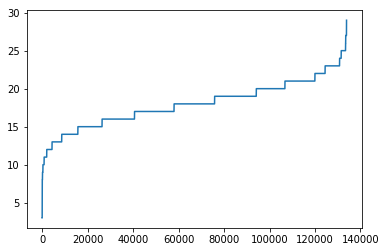

In [64]:
plt.plot( sorted(sizeswH) ) ; plt.show()

In [115]:
t1 = np.nonzero(sizeswH <= 11)[0]
t2 = np.nonzero(sizeswoH <= 6)[0]
#len(np.intersect1d(t1,t2)) # 216
len(np.setdiff1d(t1, t2))

1660

## Properties

In [91]:
np.histogram(propH, 30)[0]

array([   35,   185,   173,  1125,  1548,  4503,  5161, 11017, 12363,
       17969, 18313, 17462, 14856, 11004,  7654,  4679,  2710,  1516,
         781,   410,   228,    89,    51,    22,    13,     8,     3,
           3,     2,     2])

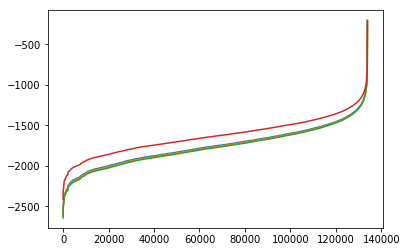

In [60]:
plt.plot(sorted(propU0))
plt.plot(sorted(propU))
plt.plot(sorted(propH))
plt.plot(sorted(propG))
plt.show()

The various energies differ by small amounts compared to the overall scale of the energies:

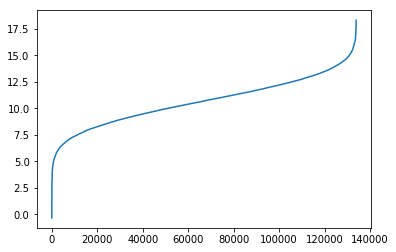

In [86]:
plt.plot(np.sort(propU0 - propU))
#plt.plot(np.sort(propU - propH))
#plt.plot(np.sort(propU0 - propG))
plt.show()

The range is densely covered in the mid-region of the S-curve:

In [87]:
print(f"U0 median consecutive difference = {np.median(np.ediff1d(np.asfarray(sorted(propU0)))):f}")
print(f"U median consecutive difference = {np.median(np.ediff1d(np.asfarray(sorted(propU)))):f}")
print(f"H median consecutive difference = {np.median(np.ediff1d(np.asfarray(sorted(propH)))):f}")
print(f"G median consecutive difference = {np.median(np.ediff1d(np.asfarray(sorted(propG)))):f}")

U0 median consecutive difference = 0.004393
U median consecutive difference = 0.004393
H median consecutive difference = 0.004393
G median consecutive difference = 0.004393


# Sampling code

In [9]:
def poormanssample(size, mols, E, indall, tolerance=0.005, minsize=2000, initialbins=30, maxsteps=1000):
    """Samples a stratified subset of given size from molecules.
    
    Parameters:
      size - size of sampled subset
      mols - dataset to sample from
      indall - valid indices in dataset to use.
      tolerance - base tolerated deviation in each statistic in percent
      minsize - minimum number of molecules required in a bin
      initialbins - number of bins to start with
      maxsteps - maximum number of steps taken
      
    Returns:
      indices of subset"""
    
    # ------- setup -------
    
    done = False           # termination condition
    iterations = 0         # iteration counter
    temperature = 0.002    # simulated annealing temperature, on a scale of fractions
    indsel = np.random.choice(indall, size, replace=False) # initial random sample
    history = np.asfarray( [[0,0,0,0,0,0]] )
    
    # statistics to consider
    # each function f(value, mols, ind) returns those positions in ind for which the statistic takes on the given value
    def fel(el, ind):
        return np.nonzero( np.asarray( [1 if el in an else 0 for an in mols['atomic_numbers'][ind]] ) )[0]
    def fsizewoH(s, ind):
        return np.nonzero( np.asarray( [1 if np.count_nonzero(an != 1) == s else 0 for an in mols['atomic_numbers'][ind]] ) )[0]
    def fsizewH(s, ind):
        return np.nonzero( np.asarray( [1 if s[0] <= len(an) < s[1] else 0 for an in mols['atomic_numbers'][ind]] ) )[0]
    def fE(s, ind):
        return np.nonzero( np.asarray( [1 if s[0] <= e < s[1] else 0 for e in E[ind]] ) )[0]
    
    # statistics functions
    # these define the statistics which are compared between sample and whole dataset
    # entries are (statfunction, value, name)
    statfuns = [
        # elemental composition
        # almost all molecules have carbon, no need to check
        [fel, 7, "N" ],
        [fel, 8, "O" ],
        [fel, 9, "Fl"],
        
        # size without H
        # sizes up to and including 6 have been excluded
        [fsizewoH, 7, "woH-7"],
        [fsizewoH, 8, "woH-8"],
        [fsizewoH, 9, "woH-9"],
    ]

    # sizewH statistics
    sizewH = np.asarray( [len(an) for an in mols['atomic_numbers'][indall]] )
    sbins = np.arange(max(sizewH)+2)
    snums = np.full(len(sbins)-1, 0, dtype=np.int)
    for s in sizewH: snums[s] += 1
    while len(snums) > 1 and min(snums) < minsize: # lump together bins that are too small
        for i in range(len(snums)):
            if snums[i] < minsize:
                if i == len(snums)-1: i = i - 1  # special case of merging last entry
                snums[i] += snums[i+1]
                snums = np.delete(snums, [i+1])
                sbins = np.delete(sbins, [i+1])
                break
    for i in range(1,len(sbins)):
        statfuns.append( [fsizewH, (sbins[i-1], sbins[i]), f"wH-{i:2}"] )

    # energy statistics
    enums,ebins = np.histogram(E, initialbins)
    while len(enums) > 1 and min(enums) < minsize: # lump together bins that are too small
        for i in range(len(enums)):
            if enums[i] < minsize:
                if i == len(enums)-1: i = i - 1  # special case of merging last entry
                enums[i] += enums[i+1]
                enums = np.delete(enums, [i+1])
                ebins = np.delete(ebins, [i+1])
                break
    for i in range(1,len(ebins)):
        statfuns.append( [fE, (ebins[i-1], ebins[i]), f"E-{i:2}"] )

    statfuns, numstatfuns = np.asarray(statfuns), len(statfuns)
    print(f"{numstatfuns:d} statistics in total, {len(sbins):d} sizewH bins, {len(ebins):d} energy bins.\n")
    
    # ------- Monte Carlo loop -------
    
    def step(sf, dev, aux):
        nonlocal done, indsel
        indstatall, indstatsel, pcall, pcsel, name = aux

        # check if within tolerance, correct if not
        if pcall - pcsel > tolerance: 
            # add molecule with this statistic
            done = False
            i = np.random.choice( np.setdiff1d(np.arange(size), indstatsel) ) # index of molecule without statistic
            indsel[i] = np.random.choice( np.setdiff1d(indall[indstatall], indsel) ) # add molecule with statistic
            print(f"{name:7}: {pcall:6.2%} - {pcsel:6.2%} = {pcall-pcsel:6.2%} -> adding molecule")
        elif pcsel - pcall > tolerance: 
            # remove molecule with this statistic
            done = False
            i = np.random.choice(indstatsel)  # index of molecule with statistic
            indsel[i] = np.random.choice( np.setdiff1d(indall[np.setdiff1d(np.arange(len(indall)), indstatall)], indsel) )  # add molecule without statistic          
            print(f"{name:5}: {pcall:6.2%} - {pcsel:6.2%} = {pcall-pcsel:6.2%} -> removing molecule")
        else:  
            # within tolerance, do nothing
            print(f"{name:5}: {pcall:6.2%} - {pcsel:6.2%} = {pcall-pcsel:6.2%} -> okay")

    def update_devaux():
        nonlocal deviations, auxiliary
        for i in range(numstatfuns):
            indstatall = statfuns[i,0](statfuns[i,1], indall)
            indstatsel = statfuns[i,0](statfuns[i,1], indsel)
            pcall, pcsel = len(indstatall)/len(indall), len(indstatsel)/size
            deviations[i] = max( abs(pcall-pcsel), 10**-6 )  # ensure positive probabilities
            auxiliary[i] = (indstatall, indstatsel, pcall, pcsel, statfuns[i,2])

    deviations = np.full(numstatfuns, 1, dtype=np.float)
    auxiliary = np.full((numstatfuns, 5), None, dtype=np.object)
    update_devaux()
    bestdeviations, bestindsel = copy.deepcopy(deviations), copy.deepcopy(indsel)
    lastdeviations, lastindsel = copy.deepcopy(deviations), copy.deepcopy(indsel)
    while not done:
        # update loop statistics
        history = np.append(history, [[np.mean(deviations), np.max(deviations), np.mean(lastdeviations), np.max(lastdeviations), np.mean(bestdeviations), np.max(bestdeviations)]], axis=0)
        lastdeviations, lastauxiliary, lastindsel = copy.deepcopy(deviations), copy.deepcopy(auxiliary), copy.deepcopy(indsel)
        iterations += 1
        done = True
        print(f"Iteration {iterations}   (best so far: {np.mean(bestdeviations):6.2%} {np.max(bestdeviations):6.2%})")
        
        # shuffle with largest deviations weighted up, then propose move
        probabilities = deviations / np.sum(deviations)
        shuffleind = np.random.choice(numstatfuns, size=numstatfuns, replace=False, p=probabilities)
        statfuns, deviations, auxiliary = statfuns[shuffleind], deviations[shuffleind], auxiliary[shuffleind]
        for sf,d,a in zip(statfuns, deviations, auxiliary):
            if not done: break
            step(sf, d, a)

        # update deviations, auxiliary
        update_devaux()
            
        # accept or reject proposed move
        if np.max(deviations) < np.max(bestdeviations) or (np.max(deviations) == np.max(bestdeviations) and np.mean(deviations) < np.mean(bestdeviations)):
            bestdeviations, bestindsel = copy.deepcopy(deviations), copy.deepcopy(indsel)
        print(f"Last: {np.mean(lastdeviations):6.2%} {np.max(lastdeviations):6.2%}.   Current: {np.mean(deviations):6.2%} {np.max(deviations):6.2%}")
        if ( np.max(deviations) > np.max(lastdeviations) ) or \
           ( np.max(deviations) == np.max(lastdeviations) and np.mean(deviations) > np.mean(lastdeviations) ):
            probability = math.exp( - ( 3 * ( np.max(deviations) - np.max(lastdeviations) ) + ( np.mean(deviations) - np.mean(lastdeviations) ) ) / temperature )
            if np.random.random() <= probability:
                print(f"Acceptance probability: {probability:6.2%} -> accepting uphill step.")
            else:
                print(f"Acceptance probability: {probability:6.2%} -> rejecting uphill step.")
                deviations, auxiliary, indsel = copy.deepcopy(lastdeviations), copy.deepcopy(lastauxiliary), copy.deepcopy(lastindsel)
        print()
        
        if iterations >= maxsteps:
            done = True

    # print last statistics again in sorted order
    sortind = np.argsort(statfuns[:,2])
    statfuns, deviations, auxiliary = statfuns[sortind], deviations[sortind], auxiliary[sortind]
    for sf,d,a in zip(statfuns, deviations, auxiliary):
        print(f"{sf[2]:5s}: {d:6.2%}")
    print()
            
    if iterations < maxsteps:
        print(f"All statistics met, done ({iterations} iterations).")
    else:
        print(f"MAXIMUM NUMBER OF {maxsteps:d} ITERATIONS REACHED, ABORTING")
    print(f"Best solution has average deviation {np.mean(bestdeviations):6.2%} and max. deviation {np.max(bestdeviations):6.2%}.")

    history = np.delete(history, 0, 0)
    history = np.delete(history, 0, 0)

    return bestindsel, bestdeviations, history

In [ ]:
t, tdev, thist = poormanssample(10000, mols, propU0, valid2, maxsteps=5)

In [ ]:
plt.plot(thist[:,0]*100, label='avg/current')
plt.plot(thist[:,1]*100, label='max/current')
plt.plot(thist[:,4]*100, label='avg/best')
plt.plot(thist[:,5]*100, label='max/best')
plt.xlabel('iterations')
plt.ylabel('deviation / %')
plt.legend()
plt.show()

In [ ]:
t, tdev, thist = poormanssample(100, mols, propU0, valid2, maxsteps=1000)

In [ ]:
plt.plot(thist[:,0]*100, label='avg/current')
plt.plot(thist[:,1]*100, label='max/current')
plt.plot(thist[:,4]*100, label='avg/best')
plt.plot(thist[:,5]*100, label='max/best')
plt.xlabel('iterations')
plt.ylabel('deviation / %')
plt.legend()
plt.show()

# Generate subsets

In [10]:
filename = 'gdb9-14-datasplits.txt'

def run_sampling(valid, size, key, tolerance, maxsteps):
    """Samples a data subset.
    
    Parameters:
      valid - universe of indices to choose from
      size - number of indices in sampled subset
      key - string name of the sampled subset
      tolerance - tolerated deviation from whole-set statistics
      maxsteps - maximum number of Monte Carlo steps
    """
    # run sampling
    ind, dev, hist = poormanssample(size, mols, propU0, valid, tolerance=tolerance, maxsteps=maxsteps)

    # write results to file, appending
    with open(filename, 'ta', encoding='ascii') as f:
        f.write(key + ':' + ' '.join([str(i) for i in ind]) + '\n')
        
    # visualize optimization
    plt.plot(hist[:,0]*100, label='avg/current')
    plt.plot(hist[:,1]*100, label='max/current')
    plt.plot(hist[:,4]*100, label='avg/best')
    plt.plot(hist[:,5]*100, label='max/best')
    plt.xlabel('iterations')
    plt.ylabel('deviation / %')
    plt.legend()
    plt.show()

In [11]:
def load_data_splits(filename):
    with open(filename, 'rt') as f:
        raw = f.read()
    res = {}
    for line in raw.split('\n'):
        if len(line.strip()) == 0: continue
        key, data = line.split(':')
        data = np.asarray( [int(i) for i in data.split()], dtype=int )
        res[key] = data

    return res

For further runs, the following settings should be sufficient:

|size |settings |80/20 splits |
|--- |--- |--- |
|  100| 0.005 , 2500 | 0.05, 2500 |
|  250| 0.001 , 2500 | 0.01, 2500 |
|  650| 0.001 , 2500 | 0.005, 2500 |
| 1600| 0.0005, 2500 | 0.005, 2500 |
| 4000| 0.0005, 2500 | 0.001, 2500 |
|10000| 0.0005, 2500 | 0.0005, 2500 |

## Validation sets

In [10]:
valid2 = np.setdiff1d(valid, np.asarray([i for i in valid if sizeswoH[i] <= 6]))

In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-1', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.16%  0.64%)
wH- 5  : 10.58% - 10.00% =  0.58% -> adding molecule
Last:  0.16%  0.64%.   Current:  0.16%  0.63%

...

Iteration 507   (best so far:  0.03%  0.05%)
E- 1 :  2.39% -  2.35% =  0.04% -> okay
wH-13:  2.37% -  2.42% = -0.05% -> okay
wH-12:  4.89% -  4.86% =  0.03% -> okay
wH-10: 10.12% - 10.09% =  0.03% -> okay
E-10 :  8.05% -  8.06% = -0.01% -> okay
O    : 85.17% - 85.20% = -0.03% -> okay
E- 9 : 10.89% - 10.91% = -0.02% -> okay
woH-7:  2.41% -  2.38% =  0.03% -> okay
E-14 :  1.75% -  1.80% = -0.05% -> okay
N    : 61.13% - 61.10% =  0.03% -> okay
wH- 9:  9.53% -  9.49% =  0.04% -> okay
wH- 5: 10.58% - 10.53% =  0.05% -> okay
wH- 3:  5.11% -  5.16% = -0.05% -> okay
E- 7 : 13.92% - 13.87% =  0.05% -> okay
E- 4 :  8.45% -  8.48% = -0.03% -> okay
E- 3 :  4.03% -  3.98% =  0.05% -> okay
wH- 8: 13.95% - 14.00% = -0.05% -> okay
wH- 7: 13.39% - 13.44% = -0.05% -> okay
E- 5 :  9.65% -  9.69% = -0.04% -> okay
wH- 1:  2.75% -  2.70% =  0.05% -> okay
E- 6 : 13.68% - 13.71% = -0.03% -> okay
E- 8 : 13.17% - 13.16% =  0.01% -> okay
E-11 :  5.45% -  5.40% =  0.05% -> okay
wH- 6: 13.04% - 13.03% =  0.01% -> okay
E-13 :  1.84% -  1.85% = -0.01% -> okay
wH- 4:  7.83% -  7.83% = -0.00% -> okay
wH-11:  3.41% -  3.41% = -0.00% -> okay
Fl   :  1.47% -  1.48% = -0.01% -> okay
woH-8: 13.75% - 13.76% = -0.01% -> okay
woH-9: 83.84% - 83.86% = -0.02% -> okay
wH- 2:  3.02% -  3.04% = -0.02% -> okay
E-12 :  3.28% -  3.28% = -0.00% -> okay
E- 2 :  3.46% -  3.46% = -0.00% -> okay
Last:  0.03%  0.05%.   Current:  0.03%  0.05%

E- 1 :  0.04%
E- 2 :  0.00%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.04%
E- 6 :  0.03%
E- 7 :  0.05%
E- 8 :  0.01%
E- 9 :  0.02%
E-10 :  0.01%
E-11 :  0.05%
E-12 :  0.00%
E-13 :  0.01%
E-14 :  0.05%
Fl   :  0.01%
N    :  0.03%
O    :  0.03%
wH- 1:  0.05%
wH- 2:  0.02%
wH- 3:  0.05%
wH- 4:  0.00%
wH- 5:  0.05%
wH- 6:  0.01%
wH- 7:  0.05%
wH- 8:  0.05%
wH- 9:  0.04%
wH-10:  0.03%
wH-11:  0.00%
wH-12:  0.03%
wH-13:  0.05%
woH-7:  0.03%
woH-8:  0.01%
woH-9:  0.02%

All statistics met, done (507 iterations).
Best solution has average deviation  0.03% and max. deviation  0.05%.

CPU times: user 28min 25s, sys: 18.3 s, total: 28min 43s
Wall time: 28min 51s


In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-2', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.19%  0.53%)
E-10 :  8.05% -  8.58% = -0.53% -> removing molecule
Last:  0.19%  0.53%.   Current:  0.19%  0.53%

...

Iteration 484   (best so far:  0.03%  0.05%)
wH-12:  4.89% -  4.94% = -0.05% -> okay
E- 8 : 13.17% - 13.21% = -0.04% -> okay
E- 9 : 10.89% - 10.86% =  0.03% -> okay
E- 2 :  3.46% -  3.41% =  0.05% -> okay
E-11 :  5.45% -  5.43% =  0.02% -> okay
E- 4 :  8.45% -  8.49% = -0.04% -> okay
wH- 4:  7.83% -  7.78% =  0.05% -> okay
wH- 5: 10.58% - 10.60% = -0.02% -> okay
N    : 61.13% - 61.17% = -0.04% -> okay
wH- 9:  9.53% -  9.49% =  0.04% -> okay
wH- 3:  5.11% -  5.08% =  0.03% -> okay
E- 6 : 13.68% - 13.72% = -0.04% -> okay
wH-11:  3.41% -  3.44% = -0.03% -> okay
O    : 85.17% - 85.19% = -0.02% -> okay
E-12 :  3.28% -  3.31% = -0.03% -> okay
E- 1 :  2.39% -  2.42% = -0.03% -> okay
woH-8: 13.75% - 13.71% =  0.04% -> okay
woH-9: 83.84% - 83.86% = -0.02% -> okay
Fl   :  1.47% -  1.51% = -0.04% -> okay
wH- 1:  2.75% -  2.79% = -0.04% -> okay
E-13 :  1.84% -  1.80% =  0.04% -> okay
wH- 7: 13.39% - 13.40% = -0.01% -> okay
E-14 :  1.75% -  1.72% =  0.03% -> okay
woH-7:  2.41% -  2.43% = -0.02% -> okay
E- 7 : 13.92% - 13.90% =  0.02% -> okay
wH- 8: 13.95% - 13.97% = -0.02% -> okay
wH- 6: 13.04% - 13.00% =  0.04% -> okay
wH- 2:  3.02% -  2.99% =  0.03% -> okay
wH-10: 10.12% - 10.15% = -0.03% -> okay
E-10 :  8.05% -  8.06% = -0.01% -> okay
wH-13:  2.37% -  2.37% =  0.00% -> okay
E- 5 :  9.65% -  9.66% = -0.01% -> okay
E- 3 :  4.03% -  4.01% =  0.02% -> okay
Last:  0.03%  0.05%.   Current:  0.03%  0.05%

E- 1 :  0.03%
E- 2 :  0.05%
E- 3 :  0.02%
E- 4 :  0.04%
E- 5 :  0.01%
E- 6 :  0.04%
E- 7 :  0.02%
E- 8 :  0.04%
E- 9 :  0.03%
E-10 :  0.01%
E-11 :  0.02%
E-12 :  0.03%
E-13 :  0.04%
E-14 :  0.03%
Fl   :  0.04%
N    :  0.04%
O    :  0.02%
wH- 1:  0.04%
wH- 2:  0.03%
wH- 3:  0.03%
wH- 4:  0.05%
wH- 5:  0.02%
wH- 6:  0.04%
wH- 7:  0.01%
wH- 8:  0.02%
wH- 9:  0.04%
wH-10:  0.03%
wH-11:  0.03%
wH-12:  0.05%
wH-13:  0.00%
woH-7:  0.02%
woH-8:  0.04%
woH-9:  0.02%

All statistics met, done (484 iterations).
Best solution has average deviation  0.03% and max. deviation  0.05%.

CPU times: user 45min 32s, sys: 40.9 s, total: 46min 13s
Wall time: 51min 14s

In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-3', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.28%  1.01%)
wH-10  : 10.12% -  9.61% =  0.51% -> adding molecule
Last:  0.28%  1.01%.   Current:  0.28%  1.01%

...

Iteration 640   (best so far:  0.03%  0.05%)
wH- 4:  7.83% -  7.86% = -0.03% -> okay
wH- 3:  5.11% -  5.16% = -0.05% -> okay
E-10 :  8.05% -  8.02% =  0.03% -> okay
E- 9 : 10.89% - 10.90% = -0.01% -> okay
Fl   :  1.47% -  1.52% = -0.05% -> okay
E- 5 :  9.65% -  9.69% = -0.04% -> okay
E- 6 : 13.68% - 13.73% = -0.05% -> okay
wH- 2:  3.02% -  2.99% =  0.03% -> okay
wH- 6: 13.04% - 13.02% =  0.02% -> okay
E-13 :  1.84% -  1.86% = -0.02% -> okay
E- 3 :  4.03% -  4.02% =  0.01% -> okay
E- 2 :  3.46% -  3.43% =  0.03% -> okay
N    : 61.13% - 61.09% =  0.04% -> okay
wH-12:  4.89% -  4.86% =  0.03% -> okay
wH- 9:  9.53% -  9.49% =  0.04% -> okay
O    : 85.17% - 85.21% = -0.04% -> okay
wH-13:  2.37% -  2.42% = -0.05% -> okay
wH-10: 10.12% - 10.08% =  0.04% -> okay
E-11 :  5.45% -  5.40% =  0.05% -> okay
woH-9: 83.84% - 83.82% =  0.02% -> okay
E- 8 : 13.17% - 13.16% =  0.01% -> okay
woH-7:  2.41% -  2.43% = -0.02% -> okay
E- 4 :  8.45% -  8.42% =  0.03% -> okay
wH- 7: 13.39% - 13.42% = -0.03% -> okay
wH-11:  3.41% -  3.44% = -0.03% -> okay
E- 7 : 13.92% - 13.93% = -0.01% -> okay
wH- 5: 10.58% - 10.57% =  0.01% -> okay
wH- 8: 13.95% - 13.94% =  0.01% -> okay
E- 1 :  2.39% -  2.39% =  0.00% -> okay
E-14 :  1.75% -  1.76% = -0.01% -> okay
woH-8: 13.75% - 13.75% = -0.00% -> okay
E-12 :  3.28% -  3.29% = -0.01% -> okay
wH- 1:  2.75% -  2.75% = -0.00% -> okay
Last:  0.03%  0.05%.   Current:  0.03%  0.05%

E- 1 :  0.00%
E- 2 :  0.03%
E- 3 :  0.01%
E- 4 :  0.03%
E- 5 :  0.04%
E- 6 :  0.05%
E- 7 :  0.01%
E- 8 :  0.01%
E- 9 :  0.01%
E-10 :  0.03%
E-11 :  0.05%
E-12 :  0.01%
E-13 :  0.02%
E-14 :  0.01%
Fl   :  0.05%
N    :  0.04%
O    :  0.04%
wH- 1:  0.00%
wH- 2:  0.03%
wH- 3:  0.05%
wH- 4:  0.03%
wH- 5:  0.01%
wH- 6:  0.02%
wH- 7:  0.03%
wH- 8:  0.01%
wH- 9:  0.04%
wH-10:  0.04%
wH-11:  0.03%
wH-12:  0.03%
wH-13:  0.05%
woH-7:  0.02%
woH-8:  0.00%
woH-9:  0.02%

All statistics met, done (640 iterations).
Best solution has average deviation  0.03% and max. deviation  0.05%.

CPU times: user 57min 21s, sys: 54.8 s, total: 58min 15s
Wall time: 1h 4min 48s

In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-4', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.31%  1.22%)
woH-8  : 13.75% - 12.67% =  1.08% -> adding molecule
Last:  0.31%  1.22%.   Current:  0.30%  1.21%

...

Iteration 900   (best so far:  0.03%  0.05%)
wH-13:  2.37% -  2.33% =  0.04% -> okay
wH- 4:  7.83% -  7.87% = -0.04% -> okay
E- 4 :  8.45% -  8.49% = -0.04% -> okay
wH- 2:  3.02% -  2.98% =  0.04% -> okay
E- 6 : 13.68% - 13.65% =  0.03% -> okay
Fl   :  1.47% -  1.44% =  0.03% -> okay
wH- 6: 13.04% - 13.01% =  0.03% -> okay
wH- 1:  2.75% -  2.77% = -0.02% -> okay
wH-11:  3.41% -  3.36% =  0.05% -> okay
wH- 5: 10.58% - 10.62% = -0.04% -> okay
wH- 9:  9.53% -  9.58% = -0.05% -> okay
E- 9 : 10.89% - 10.86% =  0.03% -> okay
woH-9: 83.84% - 83.86% = -0.02% -> okay
E-11 :  5.45% -  5.48% = -0.03% -> okay
woH-7:  2.41% -  2.39% =  0.02% -> okay
E-10 :  8.05% -  8.01% =  0.04% -> okay
O    : 85.17% - 85.20% = -0.03% -> okay
E- 1 :  2.39% -  2.42% = -0.03% -> okay
wH-10: 10.12% - 10.08% =  0.04% -> okay
wH-12:  4.89% -  4.91% = -0.02% -> okay
wH- 3:  5.11% -  5.16% = -0.05% -> okay
wH- 7: 13.39% - 13.35% =  0.04% -> okay
E-13 :  1.84% -  1.81% =  0.03% -> okay
E- 5 :  9.65% -  9.65% = -0.00% -> okay
E- 3 :  4.03% -  4.02% =  0.01% -> okay
wH- 8: 13.95% - 13.98% = -0.03% -> okay
E-14 :  1.75% -  1.77% = -0.02% -> okay
E- 8 : 13.17% - 13.16% =  0.01% -> okay
E- 7 : 13.92% - 13.93% = -0.01% -> okay
E-12 :  3.28% -  3.28% = -0.00% -> okay
E- 2 :  3.46% -  3.47% = -0.01% -> okay
woH-8: 13.75% - 13.75% = -0.00% -> okay
N    : 61.13% - 61.13% = -0.00% -> okay
Last:  0.03%  0.05%.   Current:  0.03%  0.05%

E- 1 :  0.03%
E- 2 :  0.01%
E- 3 :  0.01%
E- 4 :  0.04%
E- 5 :  0.00%
E- 6 :  0.03%
E- 7 :  0.01%
E- 8 :  0.01%
E- 9 :  0.03%
E-10 :  0.04%
E-11 :  0.03%
E-12 :  0.00%
E-13 :  0.03%
E-14 :  0.02%
Fl   :  0.03%
N    :  0.00%
O    :  0.03%
wH- 1:  0.02%
wH- 2:  0.04%
wH- 3:  0.05%
wH- 4:  0.04%
wH- 5:  0.04%
wH- 6:  0.03%
wH- 7:  0.04%
wH- 8:  0.03%
wH- 9:  0.05%
wH-10:  0.04%
wH-11:  0.05%
wH-12:  0.02%
wH-13:  0.04%
woH-7:  0.02%
woH-8:  0.00%
woH-9:  0.02%

All statistics met, done (900 iterations).
Best solution has average deviation  0.03% and max. deviation  0.05%.

CPU times: user 1h 9min 12s, sys: 1min 4s, total: 1h 10min 17s
Wall time: 1h 16min 39s

In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-5', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.22%  0.79%)
wH-13:  2.37% -  2.64% = -0.27% -> removing molecule
Last:  0.22%  0.79%.   Current:  0.22%  0.79%

...

Iteration 619   (best so far:  0.03%  0.05%)
wH- 2:  3.02% -  2.98% =  0.04% -> okay
E-13 :  1.84% -  1.86% = -0.02% -> okay
E- 9 : 10.89% - 10.93% = -0.04% -> okay
E- 4 :  8.45% -  8.49% = -0.04% -> okay
wH- 8: 13.95% - 14.00% = -0.05% -> okay
wH- 5: 10.58% - 10.55% =  0.03% -> okay
wH- 9:  9.53% -  9.58% = -0.05% -> okay
E- 1 :  2.39% -  2.44% = -0.05% -> okay
E- 2 :  3.46% -  3.44% =  0.02% -> okay
wH- 4:  7.83% -  7.79% =  0.04% -> okay
E-11 :  5.45% -  5.44% =  0.01% -> okay
wH- 3:  5.11% -  5.15% = -0.04% -> okay
wH-13:  2.37% -  2.40% = -0.03% -> okay
Fl   :  1.47% -  1.51% = -0.04% -> okay
E- 5 :  9.65% -  9.60% =  0.05% -> okay
N    : 61.13% - 61.12% =  0.01% -> okay
wH- 1:  2.75% -  2.76% = -0.01% -> okay
E- 6 : 13.68% - 13.64% =  0.04% -> okay
E- 7 : 13.92% - 13.94% = -0.02% -> okay
wH-10: 10.12% - 10.14% = -0.02% -> okay
E-14 :  1.75% -  1.71% =  0.04% -> okay
wH-11:  3.41% -  3.38% =  0.03% -> okay
woH-8: 13.75% - 13.73% =  0.02% -> okay
woH-7:  2.41% -  2.39% =  0.02% -> okay
wH- 6: 13.04% - 13.00% =  0.04% -> okay
E-12 :  3.28% -  3.25% =  0.03% -> okay
wH- 7: 13.39% - 13.37% =  0.02% -> okay
O    : 85.17% - 85.18% = -0.01% -> okay
E- 8 : 13.17% - 13.15% =  0.02% -> okay
woH-9: 83.84% - 83.88% = -0.04% -> okay
E- 3 :  4.03% -  4.04% = -0.01% -> okay
E-10 :  8.05% -  8.07% = -0.02% -> okay
wH-12:  4.89% -  4.90% = -0.01% -> okay
Last:  0.03%  0.05%.   Current:  0.03%  0.05%

E- 1 :  0.05%
E- 2 :  0.02%
E- 3 :  0.01%
E- 4 :  0.04%
E- 5 :  0.05%
E- 6 :  0.04%
E- 7 :  0.02%
E- 8 :  0.02%
E- 9 :  0.04%
E-10 :  0.02%
E-11 :  0.01%
E-12 :  0.03%
E-13 :  0.02%
E-14 :  0.04%
Fl   :  0.04%
N    :  0.01%
O    :  0.01%
wH- 1:  0.01%
wH- 2:  0.04%
wH- 3:  0.04%
wH- 4:  0.04%
wH- 5:  0.03%
wH- 6:  0.04%
wH- 7:  0.02%
wH- 8:  0.05%
wH- 9:  0.05%
wH-10:  0.02%
wH-11:  0.03%
wH-12:  0.01%
wH-13:  0.03%
woH-7:  0.02%
woH-8:  0.02%
woH-9:  0.04%

All statistics met, done (619 iterations).
Best solution has average deviation  0.03% and max. deviation  0.05%.

CPU times: user 56min 57s, sys: 32 s, total: 57min 29s
Wall time: 58min 6s

In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-6', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.20%  0.84%)
wH- 6: 13.04% - 13.22% = -0.18% -> removing molecule
Last:  0.20%  0.84%.   Current:  0.20%  0.85%
Acceptance probability: 85.94% -> accepting uphill step.

...

Iteration 676   (best so far:  0.03%  0.05%)
N    : 61.13% - 61.08% =  0.05% -> okay
wH- 4:  7.83% -  7.78% =  0.05% -> okay
E- 3 :  4.03% -  3.99% =  0.04% -> okay
wH- 8: 13.95% - 14.00% = -0.05% -> okay
wH- 7: 13.39% - 13.44% = -0.05% -> okay
E- 9 : 10.89% - 10.93% = -0.04% -> okay
wH- 6: 13.04% - 13.02% =  0.02% -> okay
E- 2 :  3.46% -  3.49% = -0.03% -> okay
O    : 85.17% - 85.20% = -0.03% -> okay
E- 1 :  2.39% -  2.37% =  0.02% -> okay
wH- 9:  9.53% -  9.58% = -0.05% -> okay
E- 6 : 13.68% - 13.64% =  0.04% -> okay
wH-13:  2.37% -  2.42% = -0.05% -> okay
E- 8 : 13.17% - 13.13% =  0.04% -> okay
E- 7 : 13.92% - 13.87% =  0.05% -> okay
wH- 2:  3.02% -  2.98% =  0.04% -> okay
wH-12:  4.89% -  4.86% =  0.03% -> okay
woH-8: 13.75% - 13.71% =  0.04% -> okay
E-13 :  1.84% -  1.86% = -0.02% -> okay
wH- 5: 10.58% - 10.53% =  0.05% -> okay
E-11 :  5.45% -  5.49% = -0.04% -> okay
wH-10: 10.12% - 10.09% =  0.03% -> okay
woH-7:  2.41% -  2.42% = -0.01% -> okay
E-10 :  8.05% -  8.10% = -0.05% -> okay
wH- 3:  5.11% -  5.11% =  0.00% -> okay
woH-9: 83.84% - 83.87% = -0.03% -> okay
E-14 :  1.75% -  1.76% = -0.01% -> okay
Fl   :  1.47% -  1.45% =  0.02% -> okay
wH-11:  3.41% -  3.43% = -0.02% -> okay
E- 5 :  9.65% -  9.67% = -0.02% -> okay
wH- 1:  2.75% -  2.76% = -0.01% -> okay
E-12 :  3.28% -  3.26% =  0.02% -> okay
E- 4 :  8.45% -  8.44% =  0.01% -> okay
Last:  0.03%  0.05%.   Current:  0.03%  0.05%

E- 1 :  0.02%
E- 2 :  0.03%
E- 3 :  0.04%
E- 4 :  0.01%
E- 5 :  0.02%
E- 6 :  0.04%
E- 7 :  0.05%
E- 8 :  0.04%
E- 9 :  0.04%
E-10 :  0.05%
E-11 :  0.04%
E-12 :  0.02%
E-13 :  0.02%
E-14 :  0.01%
Fl   :  0.02%
N    :  0.05%
O    :  0.03%
wH- 1:  0.01%
wH- 2:  0.04%
wH- 3:  0.00%
wH- 4:  0.05%
wH- 5:  0.05%
wH- 6:  0.02%
wH- 7:  0.05%
wH- 8:  0.05%
wH- 9:  0.05%
wH-10:  0.03%
wH-11:  0.02%
wH-12:  0.03%
wH-13:  0.05%
woH-7:  0.01%
woH-8:  0.04%
woH-9:  0.03%

All statistics met, done (676 iterations).
Best solution has average deviation  0.03% and max. deviation  0.05%.

CPU times: user 1h 1min 55s, sys: 33.7 s, total: 1h 2min 29s
Wall time: 1h 2min 58s

In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-7', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.22%  0.67%)
E-10 :  8.05% -  8.26% = -0.21% -> removing molecule
Last:  0.22%  0.67%.   Current:  0.22%  0.67%

...

Iteration 1039   (best so far:  0.03%  0.05%)
wH- 1:  2.75% -  2.77% = -0.02% -> okay
wH-12:  4.89% -  4.94% = -0.05% -> okay
wH- 3:  5.11% -  5.14% = -0.03% -> okay
E- 5 :  9.65% -  9.69% = -0.04% -> okay
wH- 6: 13.04% - 13.07% = -0.03% -> okay
wH- 2:  3.02% -  3.00% =  0.02% -> okay
E- 6 : 13.68% - 13.71% = -0.03% -> okay
woH-9: 83.84% - 83.81% =  0.03% -> okay
E- 2 :  3.46% -  3.42% =  0.04% -> okay
E- 4 :  8.45% -  8.42% =  0.03% -> okay
woH-8: 13.75% - 13.78% = -0.03% -> okay
wH- 4:  7.83% -  7.85% = -0.02% -> okay
E-10 :  8.05% -  8.02% =  0.03% -> okay
wH- 8: 13.95% - 13.91% =  0.04% -> okay
wH- 9:  9.53% -  9.49% =  0.04% -> okay
E- 3 :  4.03% -  3.98% =  0.05% -> okay
Fl   :  1.47% -  1.43% =  0.04% -> okay
E-12 :  3.28% -  3.32% = -0.04% -> okay
E- 8 : 13.17% - 13.13% =  0.04% -> okay
wH- 7: 13.39% - 13.35% =  0.04% -> okay
wH- 5: 10.58% - 10.61% = -0.03% -> okay
E- 1 :  2.39% -  2.37% =  0.02% -> okay
wH-10: 10.12% - 10.09% =  0.03% -> okay
E-11 :  5.45% -  5.48% = -0.03% -> okay
N    : 61.13% - 61.09% =  0.04% -> okay
O    : 85.17% - 85.17% = -0.00% -> okay
E- 7 : 13.92% - 13.95% = -0.03% -> okay
E-14 :  1.75% -  1.77% = -0.02% -> okay
E- 9 : 10.89% - 10.90% = -0.01% -> okay
wH-13:  2.37% -  2.37% =  0.00% -> okay
wH-11:  3.41% -  3.41% = -0.00% -> okay
woH-7:  2.41% -  2.41% =  0.00% -> okay
E-13 :  1.84% -  1.84% =  0.00% -> okay
Last:  0.03%  0.05%.   Current:  0.03%  0.05%

E- 1 :  0.02%
E- 2 :  0.04%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.04%
E- 6 :  0.03%
E- 7 :  0.03%
E- 8 :  0.04%
E- 9 :  0.01%
E-10 :  0.03%
E-11 :  0.03%
E-12 :  0.04%
E-13 :  0.00%
E-14 :  0.02%
Fl   :  0.04%
N    :  0.04%
O    :  0.00%
wH- 1:  0.02%
wH- 2:  0.02%
wH- 3:  0.03%
wH- 4:  0.02%
wH- 5:  0.03%
wH- 6:  0.03%
wH- 7:  0.04%
wH- 8:  0.04%
wH- 9:  0.04%
wH-10:  0.03%
wH-11:  0.00%
wH-12:  0.05%
wH-13:  0.00%
woH-7:  0.00%
woH-8:  0.03%
woH-9:  0.03%

All statistics met, done (1039 iterations).
Best solution has average deviation  0.03% and max. deviation  0.05%.

CPU times: user 1h 12min 28s, sys: 44.1 s, total: 1h 13min 13s
Wall time: 1h 13min 29s

In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-8', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.20%  0.67%)
wH- 8: 13.95% - 14.03% = -0.08% -> removing molecule
Last:  0.20%  0.67%.   Current:  0.20%  0.67%

...

Iteration 387   (best so far:  0.02%  0.05%)
E- 7 : 13.92% - 13.87% =  0.05% -> okay
wH-12:  4.89% -  4.85% =  0.04% -> okay
E- 2 :  3.46% -  3.50% = -0.04% -> okay
E-13 :  1.84% -  1.89% = -0.05% -> okay
E- 3 :  4.03% -  4.06% = -0.03% -> okay
wH- 9:  9.53% -  9.50% =  0.03% -> okay
wH- 5: 10.58% - 10.61% = -0.03% -> okay
wH-11:  3.41% -  3.36% =  0.05% -> okay
E-10 :  8.05% -  8.02% =  0.03% -> okay
O    : 85.17% - 85.12% =  0.05% -> okay
woH-7:  2.41% -  2.44% = -0.03% -> okay
E- 4 :  8.45% -  8.42% =  0.03% -> okay
E-12 :  3.28% -  3.23% =  0.05% -> okay
woH-9: 83.84% - 83.82% =  0.02% -> okay
Fl   :  1.47% -  1.49% = -0.02% -> okay
wH- 3:  5.11% -  5.16% = -0.05% -> okay
E- 9 : 10.89% - 10.88% =  0.01% -> okay
E- 5 :  9.65% -  9.63% =  0.02% -> okay
E- 8 : 13.17% - 13.19% = -0.02% -> okay
wH-13:  2.37% -  2.41% = -0.04% -> okay
wH- 1:  2.75% -  2.74% =  0.01% -> okay
N    : 61.13% - 61.09% =  0.04% -> okay
E-11 :  5.45% -  5.47% = -0.02% -> okay
wH- 4:  7.83% -  7.83% = -0.00% -> okay
E- 6 : 13.68% - 13.70% = -0.02% -> okay
woH-8: 13.75% - 13.74% =  0.01% -> okay
E- 1 :  2.39% -  2.38% =  0.01% -> okay
wH- 6: 13.04% - 13.04% =  0.00% -> okay
E-14 :  1.75% -  1.76% = -0.01% -> okay
wH-10: 10.12% - 10.13% = -0.01% -> okay
wH- 2:  3.02% -  3.02% =  0.00% -> okay
wH- 8: 13.95% - 13.96% = -0.01% -> okay
wH- 7: 13.39% - 13.39% =  0.00% -> okay
Last:  0.02%  0.05%.   Current:  0.02%  0.05%

E- 1 :  0.01%
E- 2 :  0.04%
E- 3 :  0.03%
E- 4 :  0.03%
E- 5 :  0.02%
E- 6 :  0.02%
E- 7 :  0.05%
E- 8 :  0.02%
E- 9 :  0.01%
E-10 :  0.03%
E-11 :  0.02%
E-12 :  0.05%
E-13 :  0.05%
E-14 :  0.01%
Fl   :  0.02%
N    :  0.04%
O    :  0.05%
wH- 1:  0.01%
wH- 2:  0.00%
wH- 3:  0.05%
wH- 4:  0.00%
wH- 5:  0.03%
wH- 6:  0.00%
wH- 7:  0.00%
wH- 8:  0.01%
wH- 9:  0.03%
wH-10:  0.01%
wH-11:  0.05%
wH-12:  0.04%
wH-13:  0.04%
woH-7:  0.03%
woH-8:  0.01%
woH-9:  0.02%

All statistics met, done (387 iterations).
Best solution has average deviation  0.02% and max. deviation  0.05%.

CPU times: user 33min 29s, sys: 20.4 s, total: 33min 50s
Wall time: 34min 14s

In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-9', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.17%  0.60%)
wH-12:  4.89% -  5.02% = -0.13% -> removing molecule
Last:  0.17%  0.60%.   Current:  0.17%  0.60%

...

Iteration 697   (best so far:  0.03%  0.05%)
wH- 9:  9.53% -  9.49% =  0.04% -> okay
E-14 :  1.75% -  1.71% =  0.04% -> okay
wH-12:  4.89% -  4.86% =  0.03% -> okay
wH-13:  2.37% -  2.42% = -0.05% -> okay
E- 9 : 10.89% - 10.93% = -0.04% -> okay
wH- 3:  5.11% -  5.08% =  0.03% -> okay
E- 6 : 13.68% - 13.73% = -0.05% -> okay
wH-10: 10.12% - 10.17% = -0.05% -> okay
E- 1 :  2.39% -  2.35% =  0.04% -> okay
wH- 5: 10.58% - 10.61% = -0.03% -> okay
wH- 6: 13.04% - 13.02% =  0.02% -> okay
E- 8 : 13.17% - 13.21% = -0.04% -> okay
O    : 85.17% - 85.14% =  0.03% -> okay
woH-7:  2.41% -  2.44% = -0.03% -> okay
wH-11:  3.41% -  3.43% = -0.02% -> okay
E-10 :  8.05% -  8.08% = -0.03% -> okay
E- 7 : 13.92% - 13.96% = -0.04% -> okay
wH- 2:  3.02% -  3.06% = -0.04% -> okay
E-12 :  3.28% -  3.23% =  0.05% -> okay
woH-9: 83.84% - 83.81% =  0.03% -> okay
wH- 8: 13.95% - 13.93% =  0.02% -> okay
N    : 61.13% - 61.15% = -0.02% -> okay
E- 3 :  4.03% -  3.98% =  0.05% -> okay
Fl   :  1.47% -  1.50% = -0.03% -> okay
wH- 7: 13.39% - 13.37% =  0.02% -> okay
wH- 4:  7.83% -  7.81% =  0.02% -> okay
E-11 :  5.45% -  5.46% = -0.01% -> okay
E- 4 :  8.45% -  8.41% =  0.04% -> okay
E- 2 :  3.46% -  3.47% = -0.01% -> okay
wH- 1:  2.75% -  2.75% = -0.00% -> okay
E- 5 :  9.65% -  9.64% =  0.01% -> okay
woH-8: 13.75% - 13.75% = -0.00% -> okay
E-13 :  1.84% -  1.84% =  0.00% -> okay
Last:  0.03%  0.05%.   Current:  0.03%  0.05%

E- 1 :  0.04%
E- 2 :  0.01%
E- 3 :  0.05%
E- 4 :  0.04%
E- 5 :  0.01%
E- 6 :  0.05%
E- 7 :  0.04%
E- 8 :  0.04%
E- 9 :  0.04%
E-10 :  0.03%
E-11 :  0.01%
E-12 :  0.05%
E-13 :  0.00%
E-14 :  0.04%
Fl   :  0.03%
N    :  0.02%
O    :  0.03%
wH- 1:  0.00%
wH- 2:  0.04%
wH- 3:  0.03%
wH- 4:  0.02%
wH- 5:  0.03%
wH- 6:  0.02%
wH- 7:  0.02%
wH- 8:  0.02%
wH- 9:  0.04%
wH-10:  0.05%
wH-11:  0.02%
wH-12:  0.03%
wH-13:  0.05%
woH-7:  0.03%
woH-8:  0.00%
woH-9:  0.03%

All statistics met, done (697 iterations).
Best solution has average deviation  0.03% and max. deviation  0.05%.

CPU times: user 59min 53s, sys: 34.8 s, total: 1h 27s
Wall time: 1h 57s

In [ ]:
%%time
run_sampling(valid2, 10000, 'ov-10', 0.0005, 2500)

33 statistics in total, 14 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.22%  0.72%)
woH-9  : 83.84% - 83.44% =  0.40% -> adding molecule
Last:  0.22%  0.72%.   Current:  0.22%  0.71%

...

Iteration 505   (best so far:  0.03%  0.05%)
E-14 :  1.75% -  1.71% =  0.04% -> okay
E- 8 : 13.17% - 13.15% =  0.02% -> okay
wH- 2:  3.02% -  2.98% =  0.04% -> okay
woH-8: 13.75% - 13.70% =  0.05% -> okay
E- 1 :  2.39% -  2.35% =  0.04% -> okay
E-11 :  5.45% -  5.49% = -0.04% -> okay
E- 6 : 13.68% - 13.73% = -0.05% -> okay
wH- 8: 13.95% - 13.91% =  0.04% -> okay
wH-13:  2.37% -  2.40% = -0.03% -> okay
wH-10: 10.12% - 10.08% =  0.04% -> okay
wH- 4:  7.83% -  7.86% = -0.03% -> okay
Fl   :  1.47% -  1.43% =  0.04% -> okay
E-12 :  3.28% -  3.32% = -0.04% -> okay
wH-12:  4.89% -  4.85% =  0.04% -> okay
wH- 9:  9.53% -  9.53% =  0.00% -> okay
N    : 61.13% - 61.10% =  0.03% -> okay
wH- 5: 10.58% - 10.62% = -0.04% -> okay
O    : 85.17% - 85.13% =  0.04% -> okay
E- 4 :  8.45% -  8.47% = -0.02% -> okay
woH-7:  2.41% -  2.46% = -0.05% -> okay
E-13 :  1.84% -  1.82% =  0.02% -> okay
E- 2 :  3.46% -  3.47% = -0.01% -> okay
E-10 :  8.05% -  8.04% =  0.01% -> okay
wH- 6: 13.04% - 13.07% = -0.03% -> okay
wH- 7: 13.39% - 13.40% = -0.01% -> okay
wH- 1:  2.75% -  2.79% = -0.04% -> okay
E- 7 : 13.92% - 13.89% =  0.03% -> okay
E- 9 : 10.89% - 10.88% =  0.01% -> okay
wH-11:  3.41% -  3.40% =  0.01% -> okay
E- 3 :  4.03% -  4.03% = -0.00% -> okay
wH- 3:  5.11% -  5.11% =  0.00% -> okay
E- 5 :  9.65% -  9.65% = -0.00% -> okay
woH-9: 83.84% - 83.84% = -0.00% -> okay
Last:  0.03%  0.05%.   Current:  0.03%  0.05%

E- 1 :  0.04%
E- 2 :  0.01%
E- 3 :  0.00%
E- 4 :  0.02%
E- 5 :  0.00%
E- 6 :  0.05%
E- 7 :  0.03%
E- 8 :  0.02%
E- 9 :  0.01%
E-10 :  0.01%
E-11 :  0.04%
E-12 :  0.04%
E-13 :  0.02%
E-14 :  0.04%
Fl   :  0.04%
N    :  0.03%
O    :  0.04%
wH- 1:  0.04%
wH- 2:  0.04%
wH- 3:  0.00%
wH- 4:  0.03%
wH- 5:  0.04%
wH- 6:  0.03%
wH- 7:  0.01%
wH- 8:  0.04%
wH- 9:  0.00%
wH-10:  0.04%
wH-11:  0.01%
wH-12:  0.04%
wH-13:  0.03%
woH-7:  0.05%
woH-8:  0.05%
woH-9:  0.00%

All statistics met, done (505 iterations).
Best solution has average deviation  0.03% and max. deviation  0.05%.

CPU times: user 43min 20s, sys: 24.9 s, total: 43min 45s
Wall time: 44min 6s

## Outer training sets and internal splits

### k=1 (with logging)

In [16]:
inds = load_data_splits(filename)
valid2 = np.setdiff1d(valid, np.asarray([i for i in valid if sizeswoH[i] <= 6]))
valid3 = np.setdiff1d(valid2, inds['ov-1'])

#### n=100

In [ ]:
%%time
run_sampling(valid3, 100, 'ot-1-100', 0.005, 5000)

0.31/0.87 reached after 5k iterations, lasting 4h 1m (CPU time)<br>
best value 0.31/0.87 reached after 3734 iterations<br>
0.32/0.89 was reached after 1050 iterations<br>

Log excerpt:

    33 statistics in total, 14 sizewH bins, 15 energy bins.
    
    Iteration 1   (best so far:  2.53%  8.08%)
    E- 9   : 10.89% -  4.00% =  6.89% -> adding molecule
    Last:  2.53%  8.08%.   Current:  2.50%  8.08%
    
    ...
    
    Iteration 5000   (best so far:  0.31%  0.87%)
    E-12 :  3.28% -  4.00% = -0.72% -> removing molecule
    Last:  0.55%  1.17%.   Current:  0.54%  1.17%
    
    E- 1 :  0.60%
    E- 2 :  0.54%
    E- 3 :  0.03%
    E- 4 :  0.44%
    E- 5 :  0.65%
    E- 6 :  0.32%
    E- 7 :  0.08%
    E- 8 :  0.17%
    E- 9 :  1.11%
    E-10 :  1.05%
    E-11 :  0.45%
    E-12 :  0.28%
    E-13 :  0.16%
    E-14 :  0.25%
    Fl   :  0.53%
    N    :  0.87%
    O    :  0.84%
    wH- 1:  0.25%
    wH- 2:  1.02%
    wH- 3:  0.89%
    wH- 4:  1.17%
    wH- 5:  0.58%
    wH- 6:  1.04%
    wH- 7:  0.61%
    wH- 8:  0.95%
    wH- 9:  0.46%
    wH-10:  0.87%
    wH-11:  0.40%
    wH-12:  0.10%
    wH-13:  0.37%
    woH-7:  0.42%
    woH-8:  0.25%
    woH-9:  0.16%
    
    MAXIMUM NUMBER OF 5000 ITERATIONS REACHED, ABORTING
    Best solution has average deviation  0.31% and max. deviation  0.87%.
    
    CPU times: user 3h 58min 16s, sys: 3min 12s, total: 4h 1min 28s
    Wall time: 4h 15min 58s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-1', 0.05, 2500)

E- 1 :  2.00%
E- 2 :  3.00%
E- 3 :  1.00%
E- 4 :  3.00%
E- 5 :  0.00%
E- 6 :  1.00%
E- 7 :  1.00%
E- 8 :  2.00%
E- 9 :  4.00%
E-10 :  3.00%
E-11 :  1.00%
E-12 :  2.00%
E-13 :  2.00%
E-14 :  3.00%
Fl   :  3.00%
N    :  3.00%
O    :  0.00%
wH- 1:  0.00%
woH-7:  3.00%
woH-8:  1.00%
woH-9:  4.00%

All statistics met, done (13 iterations).
Best solution has average deviation  2.00% and max. deviation  4.00%.

CPU times: user 218 ms, sys: 18.9 ms, total: 236 ms
Wall time: 232 ms

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-2', 0.05, 2500)

E- 1 :  2.00%
E- 2 :  2.00%
E- 3 :  4.00%
E- 4 :  3.00%
E- 5 :  0.00%
E- 6 :  1.00%
E- 7 :  1.00%
E- 8 :  2.00%
E- 9 :  4.00%
E-10 :  2.00%
E-11 :  4.00%
E-12 :  3.00%
E-13 :  2.00%
E-14 :  2.00%
Fl   :  2.00%
N    :  2.00%
O    :  0.00%
wH- 1:  0.00%
woH-7:  2.00%
woH-8:  1.00%
woH-9:  1.00%

All statistics met, done (20 iterations).
Best solution has average deviation  1.90% and max. deviation  4.00%.

CPU times: user 258 ms, sys: 32.2 ms, total: 291 ms
Wall time: 271 ms



In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-3', 0.05, 2500)

E- 1 :  2.00%
E- 2 :  3.00%
E- 3 :  1.00%
E- 4 :  2.00%
E- 5 :  5.00%
E- 6 :  1.00%
E- 7 :  1.00%
E- 8 :  3.00%
E- 9 :  1.00%
E-10 :  3.00%
E-11 :  1.00%
E-12 :  2.00%
E-13 :  3.00%
E-14 :  2.00%
Fl   :  2.00%
N    :  3.00%
O    :  5.00%
wH- 1:  0.00%
woH-7:  2.00%
woH-8:  1.00%
woH-9:  1.00%

All statistics met, done (16 iterations).
Best solution has average deviation  2.10% and max. deviation  5.00%.

CPU times: user 231 ms, sys: 25.3 ms, total: 256 ms
Wall time: 239 ms

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-4', 0.05, 2500)

E- 1 :  3.00%
E- 2 :  3.00%
E- 3 :  1.00%
E- 4 :  3.00%
E- 5 :  5.00%
E- 6 :  4.00%
E- 7 :  1.00%
E- 8 :  3.00%
E- 9 :  4.00%
E-10 :  2.00%
E-11 :  4.00%
E-12 :  2.00%
E-13 :  3.00%
E-14 :  2.00%
Fl   :  2.00%
N    :  3.00%
O    :  0.00%
wH- 1:  0.00%
woH-7:  2.00%
woH-8:  1.00%
woH-9:  1.00%

All statistics met, done (14 iterations).
Best solution has average deviation  2.33% and max. deviation  5.00%.

CPU times: user 215 ms, sys: 22.6 ms, total: 238 ms
Wall time: 223 ms

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-5', 0.05, 2500)

E- 1 :  2.00%
E- 2 :  3.00%
E- 3 :  4.00%
E- 4 :  3.00%
E- 5 :  0.00%
E- 6 :  1.00%
E- 7 :  1.00%
E- 8 :  2.00%
E- 9 :  4.00%
E-10 :  2.00%
E-11 :  4.00%
E-12 :  2.00%
E-13 :  2.00%
E-14 :  2.00%
Fl   :  2.00%
N    :  3.00%
O    :  5.00%
wH- 1:  0.00%
woH-7:  2.00%
woH-8:  1.00%
woH-9:  1.00%

All statistics met, done (8 iterations).
Best solution has average deviation  2.19% and max. deviation  5.00%.

CPU times: user 198 ms, sys: 21.1 ms, total: 219 ms
Wall time: 205 ms

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-6', 0.05, 2500)

E- 1 :  2.00%
E- 2 :  2.00%
E- 3 :  4.00%
E- 4 :  2.00%
E- 5 :  5.00%
E- 6 :  1.00%
E- 7 :  4.00%
E- 8 :  3.00%
E- 9 :  4.00%
E-10 :  2.00%
E-11 :  4.00%
E-12 :  2.00%
E-13 :  3.00%
E-14 :  2.00%
Fl   :  2.00%
N    :  3.00%
O    :  5.00%
wH- 1:  0.00%
woH-7:  2.00%
woH-8:  1.00%
woH-9:  1.00%

All statistics met, done (21 iterations).
Best solution has average deviation  2.57% and max. deviation  5.00%.

CPU times: user 251 ms, sys: 33.6 ms, total: 285 ms
Wall time: 262 ms

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-7', 0.05, 2500)

E- 1 :  3.00%
E- 2 :  2.00%
E- 3 :  1.00%
E- 4 :  3.00%
E- 5 :  5.00%
E- 6 :  1.00%
E- 7 :  1.00%
E- 8 :  3.00%
E- 9 :  4.00%
E-10 :  3.00%
E-11 :  4.00%
E-12 :  3.00%
E-13 :  3.00%
E-14 :  2.00%
Fl   :  2.00%
N    :  3.00%
O    :  0.00%
wH- 1:  0.00%
woH-7:  2.00%
woH-8:  1.00%
woH-9:  1.00%

All statistics met, done (12 iterations).
Best solution has average deviation  2.24% and max. deviation  5.00%.

CPU times: user 200 ms, sys: 17.9 ms, total: 218 ms
Wall time: 209 ms

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-8', 0.05, 2500)

E- 1 :  2.00%
E- 2 :  2.00%
E- 3 :  1.00%
E- 4 :  3.00%
E- 5 :  5.00%
E- 6 :  1.00%
E- 7 :  1.00%
E- 8 :  3.00%
E- 9 :  1.00%
E-10 :  2.00%
E-11 :  1.00%
E-12 :  2.00%
E-13 :  2.00%
E-14 :  2.00%
Fl   :  2.00%
N    :  3.00%
O    :  0.00%
wH- 1:  0.00%
woH-7:  2.00%
woH-8:  1.00%
woH-9:  1.00%

All statistics met, done (20 iterations).
Best solution has average deviation  1.76% and max. deviation  5.00%.

CPU times: user 250 ms, sys: 31.7 ms, total: 282 ms
Wall time: 261 ms

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-9', 0.05, 2500)

E- 1 :  2.00%
E- 2 :  3.00%
E- 3 :  1.00%
E- 4 :  3.00%
E- 5 :  5.00%
E- 6 :  1.00%
E- 7 :  1.00%
E- 8 :  2.00%
E- 9 :  1.00%
E-10 :  2.00%
E-11 :  1.00%
E-12 :  3.00%
E-13 :  2.00%
E-14 :  3.00%
Fl   :  3.00%
N    :  2.00%
O    :  5.00%
wH- 1:  0.00%
woH-7:  2.00%
woH-8:  1.00%
woH-9:  1.00%

All statistics met, done (14 iterations).
Best solution has average deviation  2.10% and max. deviation  5.00%.

CPU times: user 206 ms, sys: 19.9 ms, total: 226 ms
Wall time: 214 ms

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-100'], 20, 'iv-1-100-10', 0.05, 2500)

E- 1 :  3.00%
E- 2 :  2.00%
E- 3 :  1.00%
E- 4 :  3.00%
E- 5 :  5.00%
E- 6 :  1.00%
E- 7 :  4.00%
E- 8 :  2.00%
E- 9 :  4.00%
E-10 :  2.00%
E-11 :  1.00%
E-12 :  2.00%
E-13 :  2.00%
E-14 :  2.00%
Fl   :  2.00%
N    :  2.00%
O    :  0.00%
wH- 1:  0.00%
woH-7:  3.00%
woH-8:  1.00%
woH-9:  4.00%

All statistics met, done (6 iterations).
Best solution has average deviation  2.19% and max. deviation  5.00%.

CPU times: user 177 ms, sys: 14.7 ms, total: 191 ms
Wall time: 184 ms

#### n=250

In [ ]:
%%time
run_sampling(valid3, 250, 'ot-1-250', 0.001, 2500)

0.15/0.44 reached after 5k iterations, lasting 3h 51m (CPU time)<br>
best value 0.15/0.44 reached after 559 iterations

Log excerpt:

    33 statistics in total, 14 sizewH bins, 15 energy bins.
    
    Iteration 1   (best so far:  1.48%  4.08%)
    E- 2   :  3.46% -  2.80% =  0.66% -> adding molecule
    Last:  1.48%  4.08%.   Current:  1.49%  4.08%
    Acceptance probability: 99.12% -> accepting uphill step.
    
    ...
    
    Iteration 5000   (best so far:  0.15%  0.44%)
    E-12   :  3.28% -  2.80% =  0.48% -> adding molecule
    Last:  0.32%  0.83%.   Current:  0.33%  0.83%
    Acceptance probability: 95.33% -> accepting uphill step.
    
    E- 1 :  0.00%
    E- 2 :  0.26%
    E- 3 :  0.77%
    E- 4 :  0.04%
    E- 5 :  0.45%
    E- 6 :  0.32%
    E- 7 :  0.32%
    E- 8 :  0.83%
    E- 9 :  0.31%
    E-10 :  0.45%
    E-11 :  0.25%
    E-12 :  0.08%
    E-13 :  0.24%
    E-14 :  0.15%
    Fl   :  0.27%
    N    :  0.47%
    O    :  0.44%
    wH- 1:  0.35%
    wH- 2:  0.22%
    wH- 3:  0.71%
    wH- 4:  0.57%
    wH- 5:  0.18%
    wH- 6:  0.56%
    wH- 7:  0.19%
    wH- 8:  0.45%
    wH- 9:  0.34%
    wH-10:  0.27%
    wH-11:  0.20%
    wH-12:  0.10%
    wH-13:  0.03%
    woH-7:  0.38%
    woH-8:  0.55%
    woH-9:  0.16%
    
    MAXIMUM NUMBER OF 5000 ITERATIONS REACHED, ABORTING
    Best solution has average deviation  0.15% and max. deviation  0.44%.
    
    CPU times: user 3h 49min 32s, sys: 1min 56s, total: 3h 51min 28s
    Wall time: 3h 51min 25s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-1', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  2.82%  7.20%)
E- 9 : 10.80% - 18.00% = -7.20% -> removing molecule
Last:  2.82%  7.20%.   Current:  2.82%  8.00%
Acceptance probability:  0.00% -> rejecting uphill step.

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (123 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 1.06 s, sys: 111 ms, total: 1.17 s
Wall time: 1.1 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-2', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  3.81% 10.00%)
E-12 :  3.20% -  6.00% = -2.80% -> removing molecule
Last:  3.81% 10.00%.   Current:  3.43%  8.00%

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (338 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 2.71 s, sys: 310 ms, total: 3.02 s
Wall time: 2.81 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-3', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  2.53%  7.20%)
E-14 :  1.60% -  4.00% = -2.40% -> removing molecule
Last:  2.53%  7.20%.   Current:  2.72%  6.40%

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (203 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 1.69 s, sys: 180 ms, total: 1.87 s
Wall time: 1.75 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-4', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  3.68% 12.40%)
woH-7  :  2.40% -  0.00% =  2.40% -> adding molecule
Last:  3.68% 12.40%.   Current:  3.49% 12.40%

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (107 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 993 ms, sys: 115 ms, total: 1.11 s
Wall time: 1.04 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-5', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  2.51%  8.40%)
E- 8 : 12.80% - 16.00% = -3.20% -> removing molecule
Last:  2.51%  8.40%.   Current:  2.51%  8.40%

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (183 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 1.49 s, sys: 154 ms, total: 1.64 s
Wall time: 1.54 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-6', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  2.80%  7.20%)
E-11 :  5.60% - 10.00% = -4.40% -> removing molecule
Last:  2.80%  7.20%.   Current:  2.80%  7.20%
Acceptance probability: 100.00% -> accepting uphill step.

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (236 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 1.87 s, sys: 204 ms, total: 2.07 s
Wall time: 1.93 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-7', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  2.86%  9.20%)
E- 8   : 12.80% - 10.00% =  2.80% -> adding molecule
Last:  2.86%  9.20%.   Current:  2.67%  9.20%

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (113 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 999 ms, sys: 103 ms, total: 1.1 s
Wall time: 1.04 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-8', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  2.80%  8.40%)
Fl   :  1.60% -  4.00% = -2.40% -> removing molecule
Last:  2.80%  8.40%.   Current:  2.90%  8.40%
Acceptance probability: 62.11% -> accepting uphill step.

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (108 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 968 ms, sys: 99.6 ms, total: 1.07 s
Wall time: 1 s

21 statistics in total, 2 sizewH bins, 15 energy bins.
​
Iteration 1   (best so far:  2.80%  8.40%)
Fl   :  1.60% -  4.00% = -2.40% -> removing molecule
Last:  2.80%  8.40%.   Current:  2.90%  8.40%

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-9', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  2.51%  8.40%)
E-11 :  5.60% -  8.00% = -2.40% -> removing molecule
Last:  2.51%  8.40%.   Current:  2.51% 10.40%
Acceptance probability:  0.00% -> rejecting uphill step.

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (138 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 1.23 s, sys: 144 ms, total: 1.37 s
Wall time: 1.29 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-250'], 50, 'iv-1-250-10', 0.01, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  2.65%  9.20%)
E- 6 : 13.60% - 18.00% = -4.40% -> removing molecule
Last:  2.65%  9.20%.   Current:  2.50%  9.20%

...

E- 1 :  0.40%
E- 2 :  0.40%
E- 3 :  0.00%
E- 4 :  0.40%
E- 5 :  0.40%
E- 6 :  0.40%
E- 7 :  0.00%
E- 8 :  0.80%
E- 9 :  0.80%
E-10 :  0.40%
E-11 :  0.40%
E-12 :  0.80%
E-13 :  0.00%
E-14 :  0.40%
Fl   :  0.40%
N    :  0.80%
O    :  0.40%
wH- 1:  0.00%
woH-7:  0.40%
woH-8:  0.40%
woH-9:  0.00%

All statistics met, done (112 iterations).
Best solution has average deviation  0.38% and max. deviation  0.80%.

CPU times: user 967 ms, sys: 98.6 ms, total: 1.07 s
Wall time: 1 s

#### n=650

In [ ]:
%%time
run_sampling(valid3, 650, 'ot-1-650', 0.001, 5000)

0.09/0.21 reached after 5k iterations, lasting 3h 52m (CPU time)
best value 0.09/0.21 reached after 4550 iterations
0.10/0.22 was reached after 1669 iterations

Log excerpt:

    33 statistics in total, 14 sizewH bins, 15 energy bins.

    Iteration 1   (best so far:  0.82%  3.79%)
    E- 7 : 13.92% - 15.69% = -1.77% -> removing molecule
    Last:  0.82%  3.79%.   Current:  0.81%  3.95%
    Acceptance probability: 21.81% -> rejecting uphill step.
    
    ...
    
    Iteration 5000   (best so far:  0.09%  0.21%)
    O    : 85.16% - 85.85% = -0.68% -> removing molecule
    Last:  0.14%  0.68%.   Current:  0.14%  0.53%
    
    E- 1 :  0.07%
    E- 2 :  0.07%
    E- 3 :  0.18%
    E- 4 :  0.17%
    E- 5 :  0.35%
    E- 6 :  0.32%
    E- 7 :  0.08%
    E- 8 :  0.24%
    E- 9 :  0.19%
    E-10 :  0.36%
    E-11 :  0.09%
    E-12 :  0.20%
    E-13 :  0.30%
    E-14 :  0.10%
    Fl   :  0.09%
    N    :  0.10%
    O    :  0.53%
    wH- 1:  0.29%
    wH- 2:  0.10%
    wH- 3:  0.03%
    wH- 4:  0.02%
    wH- 5:  0.04%
    wH- 6:  0.19%
    wH- 7:  0.15%
    wH- 8:  0.05%
    wH- 9:  0.00%
    wH-10:  0.03%
    wH-11:  0.02%
    wH-12:  0.03%
    wH-13:  0.06%
    woH-7:  0.05%
    woH-8:  0.05%
    woH-9:  0.01%
    
    MAXIMUM NUMBER OF 5000 ITERATIONS REACHED, ABORTING
    Best solution has average deviation  0.09% and max. deviation  0.21%.
    
    CPU times: user 3h 50min 52s, sys: 2min 5s, total: 3h 52min 58s
    Wall time: 3h 52min 59s


In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-1', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.58%  8.00%)
N      : 61.08% - 53.08% =  8.00% -> adding molecule
Last:  1.58%  8.00%.   Current:  1.68%  7.23%

...

E- 1 :  0.15%
E- 2 :  0.31%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.31%
E- 6 :  0.31%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.31%
E-11 :  0.15%
E-12 :  0.31%
E-13 :  0.31%
E-14 :  0.46%
Fl   :  0.15%
N    :  0.46%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (102 iterations).
Best solution has average deviation  0.20% and max. deviation  0.46%.

CPU times: user 1.76 s, sys: 129 ms, total: 1.88 s
Wall time: 1.79 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-2', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.94%  3.38%)
O    : 85.23% - 87.69% = -2.46% -> removing molecule
Last:  0.94%  3.38%.   Current:  1.05%  3.38%
Acceptance probability: 57.73% -> rejecting uphill step.


...

E- 1 :  0.15%
E- 2 :  0.31%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.31%
E- 6 :  0.31%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.46%
E-11 :  0.15%
E-12 :  0.46%
E-13 :  0.46%
E-14 :  0.31%
Fl   :  0.15%
N    :  0.46%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (72 iterations).
Best solution has average deviation  0.21% and max. deviation  0.46%.

CPU times: user 1.28 s, sys: 88.4 ms, total: 1.37 s
Wall time: 1.32 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-3', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.74%  7.23%)
E- 9   : 10.92% - 10.00% =  0.92% -> adding molecule
Last:  1.74%  7.23%.   Current:  1.67%  7.23%

...

E- 1 :  0.15%
E- 2 :  0.31%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.31%
E- 6 :  0.31%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.46%
E-11 :  0.15%
E-12 :  0.46%
E-13 :  0.46%
E-14 :  0.31%
Fl   :  0.15%
N    :  0.31%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (108 iterations).
Best solution has average deviation  0.21% and max. deviation  0.46%.

CPU times: user 1.91 s, sys: 139 ms, total: 2.05 s
Wall time: 1.96 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-4', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.88%  4.46%)
Fl     :  1.38% -  0.77% =  0.62% -> adding molecule
Last:  1.88%  4.46%.   Current:  1.68%  3.85%

...

E- 1 :  0.15%
E- 2 :  0.46%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.46%
E- 6 :  0.46%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.31%
E-11 :  0.15%
E-12 :  0.31%
E-13 :  0.46%
E-14 :  0.46%
Fl   :  0.15%
N    :  0.46%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (77 iterations).
Best solution has average deviation  0.23% and max. deviation  0.46%.

CPU times: user 1.41 s, sys: 96.5 ms, total: 1.5 s
Wall time: 1.45 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-5', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.78%  6.00%)
E-10   :  8.15% -  6.92% =  1.23% -> adding molecule
Last:  1.78%  6.00%.   Current:  1.66%  5.23%

...

E- 1 :  0.15%
E- 2 :  0.46%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.31%
E- 6 :  0.31%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.31%
E-11 :  0.15%
E-12 :  0.31%
E-13 :  0.31%
E-14 :  0.31%
Fl   :  0.15%
N    :  0.46%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (146 iterations).
Best solution has average deviation  0.20% and max. deviation  0.46%.

CPU times: user 2.56 s, sys: 205 ms, total: 2.76 s
Wall time: 2.63 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-6', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.27%  6.31%)
E- 6   : 13.54% - 10.77% =  2.77% -> adding molecule
Last:  1.27%  6.31%.   Current:  1.25%  6.31%

...

E- 1 :  0.15%
E- 2 :  0.31%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.31%
E- 6 :  0.46%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.31%
E-11 :  0.15%
E-12 :  0.46%
E-13 :  0.46%
E-14 :  0.31%
Fl   :  0.15%
N    :  0.31%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (95 iterations).
Best solution has average deviation  0.21% and max. deviation  0.46%.

CPU times: user 1.7 s, sys: 120 ms, total: 1.82 s
Wall time: 1.75 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-7', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.63%  4.62%)
E- 8 : 13.08% - 17.69% = -4.62% -> removing molecule
Last:  1.63%  4.62%.   Current:  1.63%  4.31%

...

E- 1 :  0.15%
E- 2 :  0.31%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.31%
E- 6 :  0.31%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.31%
E-11 :  0.15%
E-12 :  0.46%
E-13 :  0.31%
E-14 :  0.31%
Fl   :  0.15%
N    :  0.46%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (79 iterations).
Best solution has average deviation  0.20% and max. deviation  0.46%.

CPU times: user 1.39 s, sys: 91.3 ms, total: 1.48 s
Wall time: 1.42 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-8', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.32%  5.38%)
E- 7   : 13.85% -  9.23% =  4.62% -> adding molecule
Last:  1.32%  5.38%.   Current:  1.21%  5.38%

...

E- 1 :  0.15%
E- 2 :  0.31%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.31%
E- 6 :  0.46%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.31%
E-11 :  0.15%
E-12 :  0.46%
E-13 :  0.31%
E-14 :  0.46%
Fl   :  0.15%
N    :  0.31%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (32 iterations).
Best solution has average deviation  0.21% and max. deviation  0.46%.

CPU times: user 654 ms, sys: 40.3 ms, total: 694 ms
Wall time: 669 ms

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-9', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.95% 12.62%)
N      : 61.08% - 48.46% = 12.62% -> adding molecule
Last:  1.95% 12.62%.   Current:  1.88% 11.85%

...

E- 1 :  0.15%
E- 2 :  0.46%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.46%
E- 6 :  0.31%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.46%
E-11 :  0.15%
E-12 :  0.46%
E-13 :  0.46%
E-14 :  0.31%
Fl   :  0.15%
N    :  0.46%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (127 iterations).
Best solution has average deviation  0.23% and max. deviation  0.46%.

CPU times: user 2.17 s, sys: 155 ms, total: 2.32 s
Wall time: 2.21 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-650'], 130, 'iv-1-650-10', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.51%  4.15%)
E- 7 : 13.85% - 15.38% = -1.54% -> removing molecule
Last:  1.51%  4.15%.   Current:  1.44%  4.15%

...

E- 1 :  0.15%
E- 2 :  0.46%
E- 3 :  0.00%
E- 4 :  0.00%
E- 5 :  0.31%
E- 6 :  0.46%
E- 7 :  0.00%
E- 8 :  0.00%
E- 9 :  0.15%
E-10 :  0.31%
E-11 :  0.15%
E-12 :  0.31%
E-13 :  0.46%
E-14 :  0.31%
Fl   :  0.15%
N    :  0.46%
O    :  0.15%
wH- 1:  0.00%
woH-7:  0.15%
woH-8:  0.31%
woH-9:  0.15%

All statistics met, done (90 iterations).
Best solution has average deviation  0.21% and max. deviation  0.46%.

CPU times: user 1.54 s, sys: 95.6 ms, total: 1.64 s
Wall time: 1.59 s

#### n=1600

In [ ]:
%%time
run_sampling(valid3, 1600, 'ot-1-1600', 0.0005, 5000)

0.03/0.06 reached after 5k iterations, lasing 3h 59m (CPU time).
best value 0.03/0.06 reached after 1684 iterations.

Log excerpt:

    33 statistics in total, 14 sizewH bins, 15 energy bins.
    
    Iteration 1   (best so far:  0.54%  1.51%)
    woH-9  : 83.84% - 83.19% =  0.65% -> adding molecule
    Last:  0.54%  1.51%.   Current:  0.53%  1.51%
    
    Iteration 5000   (best so far:  0.03%  0.06%)
    wH- 2:  3.02% -  3.06% = -0.04% -> okay
    wH-11:  3.40% -  3.44% = -0.03% -> okay
    wH- 4  :  7.83% -  7.75% =  0.08% -> adding molecule
    Last:  0.06%  0.17%.   Current:  0.06%  0.17%
    
    E- 1 :  0.02%
    E- 2 :  0.02%
    E- 3 :  0.03%
    E- 4 :  0.06%
    E- 5 :  0.02%
    E- 6 :  0.07%
    E- 7 :  0.11%
    E- 8 :  0.02%
    E- 9 :  0.07%
    E-10 :  0.11%
    E-11 :  0.17%
    E-12 :  0.03%
    E-13 :  0.04%
    E-14 :  0.00%
    Fl   :  0.03%
    N    :  0.13%
    O    :  0.15%
    wH- 1:  0.00%
    wH- 2:  0.04%
    wH- 3:  0.04%
    wH- 4:  0.01%
    wH- 5:  0.11%
    wH- 6:  0.08%
    wH- 7:  0.01%
    wH- 8:  0.01%
    wH- 9:  0.10%
    wH-10:  0.06%
    wH-11:  0.03%
    wH-12:  0.02%
    wH-13:  0.01%
    woH-7:  0.02%
    woH-8:  0.12%
    woH-9:  0.10%
    
    MAXIMUM NUMBER OF 5000 ITERATIONS REACHED, ABORTING
    Best solution has average deviation  0.03% and max. deviation  0.06%.

    CPU times: user 3h 57min 2s, sys: 2min 24s, total: 3h 59min 27s
    Wall time: 4h 12s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-1', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.00%  3.31%)
E-10   :  8.06% -  5.62% =  2.44% -> adding molecule
Last:  1.00%  3.31%.   Current:  0.99%  3.00%

...

E- 1 :  0.19%
E- 2 :  0.38%
E- 3 :  0.31%
E- 4 :  0.31%
E- 5 :  0.31%
E- 6 :  0.19%
E- 7 :  0.13%
E- 8 :  0.31%
E- 9 :  0.38%
E-10 :  0.25%
E-11 :  0.19%
E-12 :  0.44%
E-13 :  0.31%
E-14 :  0.44%
Fl   :  0.06%
N    :  0.19%
O    :  0.19%
wH- 1:  0.00%
woH-7:  0.38%
woH-8:  0.31%
woH-9:  0.06%

All statistics met, done (60 iterations).
Best solution has average deviation  0.25% and max. deviation  0.44%.

CPU times: user 2.25 s, sys: 65.3 ms, total: 2.32 s
Wall time: 2.28 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-2', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.84%  2.50%)
woH-9: 83.81% - 84.06% = -0.25% -> okay
Fl     :  1.50% -  0.62% =  0.87% -> adding molecule
Last:  0.84%  2.50%.   Current:  0.81%  2.50%

...

E- 1 :  0.19%
E- 2 :  0.25%
E- 3 :  0.31%
E- 4 :  0.31%
E- 5 :  0.31%
E- 6 :  0.19%
E- 7 :  0.44%
E- 8 :  0.31%
E- 9 :  0.25%
E-10 :  0.25%
E-11 :  0.19%
E-12 :  0.50%
E-13 :  0.31%
E-14 :  0.19%
Fl   :  0.25%
N    :  0.13%
O    :  0.44%
wH- 1:  0.00%
woH-7:  0.38%
woH-8:  0.31%
woH-9:  0.06%

All statistics met, done (50 iterations).
Best solution has average deviation  0.26% and max. deviation  0.50%.

CPU times: user 2.05 s, sys: 62.6 ms, total: 2.12 s
Wall time: 2.22 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-3', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.12%  3.19%)
woH-7:  2.44% -  4.06% = -1.62% -> removing molecule
Last:  1.12%  3.19%.   Current:  1.05%  2.88%

...

E- 1 :  0.44%
E- 2 :  0.25%
E- 3 :  0.31%
E- 4 :  0.31%
E- 5 :  0.31%
E- 6 :  0.13%
E- 7 :  0.19%
E- 8 :  0.31%
E- 9 :  0.25%
E-10 :  0.25%
E-11 :  0.13%
E-12 :  0.44%
E-13 :  0.00%
E-14 :  0.19%
Fl   :  0.25%
N    :  0.44%
O    :  0.44%
wH- 1:  0.00%
woH-7:  0.25%
woH-8:  0.00%
woH-9:  0.25%

All statistics met, done (63 iterations).
Best solution has average deviation  0.24% and max. deviation  0.44%.

CPU times: user 2.45 s, sys: 82.6 ms, total: 2.53 s
Wall time: 2.58 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-4', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.93%  3.00%)
woH-9: 83.81% - 84.38% = -0.56% -> removing molecule
Last:  0.93%  3.00%.   Current:  0.96%  3.31%
Acceptance probability:  0.79% -> rejecting uphill step.


...

E- 1 :  0.44%
E- 2 :  0.25%
E- 3 :  0.00%
E- 4 :  0.31%
E- 5 :  0.31%
E- 6 :  0.19%
E- 7 :  0.19%
E- 8 :  0.31%
E- 9 :  0.25%
E-10 :  0.25%
E-11 :  0.44%
E-12 :  0.50%
E-13 :  0.31%
E-14 :  0.12%
Fl   :  0.38%
N    :  0.44%
O    :  0.19%
wH- 1:  0.00%
woH-7:  0.06%
woH-8:  0.00%
woH-9:  0.06%

All statistics met, done (65 iterations).
Best solution has average deviation  0.24% and max. deviation  0.50%.

CPU times: user 2.44 s, sys: 74.2 ms, total: 2.52 s
Wall time: 2.54 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-5', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.03%  3.12%)
woH-8: 13.75% - 15.31% = -1.56% -> removing molecule
Last:  1.03%  3.12%.   Current:  0.96%  2.81%

...

E- 1 :  0.19%
E- 2 :  0.06%
E- 3 :  0.00%
E- 4 :  0.31%
E- 5 :  0.00%
E- 6 :  0.19%
E- 7 :  0.44%
E- 8 :  0.31%
E- 9 :  0.25%
E-10 :  0.06%
E-11 :  0.19%
E-12 :  0.44%
E-13 :  0.31%
E-14 :  0.12%
Fl   :  0.25%
N    :  0.19%
O    :  0.44%
wH- 1:  0.00%
woH-7:  0.25%
woH-8:  0.31%
woH-9:  0.06%

All statistics met, done (67 iterations).
Best solution has average deviation  0.21% and max. deviation  0.44%.

CPU times: user 2.51 s, sys: 84.2 ms, total: 2.59 s
Wall time: 2.62 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-6', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.07%  3.31%)
woH-7:  2.44% -  2.81% = -0.38% -> okay
E- 4 :  8.44% -  9.69% = -1.25% -> removing molecule
Last:  1.07%  3.31%.   Current:  1.07%  3.31%

...

E- 1 :  0.19%
E- 2 :  0.25%
E- 3 :  0.31%
E- 4 :  0.31%
E- 5 :  0.31%
E- 6 :  0.19%
E- 7 :  0.19%
E- 8 :  0.00%
E- 9 :  0.25%
E-10 :  0.38%
E-11 :  0.19%
E-12 :  0.19%
E-13 :  0.31%
E-14 :  0.19%
Fl   :  0.25%
N    :  0.19%
O    :  0.44%
wH- 1:  0.00%
woH-7:  0.06%
woH-8:  0.31%
woH-9:  0.38%

All statistics met, done (60 iterations).
Best solution has average deviation  0.23% and max. deviation  0.44%.

CPU times: user 2.33 s, sys: 66.2 ms, total: 2.39 s
Wall time: 2.44 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-7', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.09%  3.56%)
E- 7 : 13.94% - 17.50% = -3.56% -> removing molecule
Last:  1.09%  3.56%.   Current:  1.06%  3.25%

...

E- 1 :  0.13%
E- 2 :  0.25%
E- 3 :  0.31%
E- 4 :  0.00%
E- 5 :  0.31%
E- 6 :  0.19%
E- 7 :  0.44%
E- 8 :  0.00%
E- 9 :  0.06%
E-10 :  0.25%
E-11 :  0.44%
E-12 :  0.44%
E-13 :  0.00%
E-14 :  0.44%
Fl   :  0.25%
N    :  0.44%
O    :  0.19%
wH- 1:  0.00%
woH-7:  0.38%
woH-8:  0.31%
woH-9:  0.06%

All statistics met, done (56 iterations).
Best solution has average deviation  0.23% and max. deviation  0.44%.

CPU times: user 2.2 s, sys: 70.3 ms, total: 2.27 s
Wall time: 2.34 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-8', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.01%  2.44%)
E- 5   :  9.69% -  9.06% =  0.63% -> adding molecule
Last:  1.01%  2.44%.   Current:  1.02%  2.62%
Acceptance probability:  5.57% -> rejecting uphill step.

...

E- 1 :  0.19%
E- 2 :  0.25%
E- 3 :  0.00%
E- 4 :  0.31%
E- 5 :  0.31%
E- 6 :  0.19%
E- 7 :  0.19%
E- 8 :  0.00%
E- 9 :  0.06%
E-10 :  0.25%
E-11 :  0.19%
E-12 :  0.19%
E-13 :  0.00%
E-14 :  0.12%
Fl   :  0.38%
N    :  0.19%
O    :  0.12%
wH- 1:  0.00%
woH-7:  0.06%
woH-8:  0.31%
woH-9:  0.25%

All statistics met, done (63 iterations).
Best solution has average deviation  0.17% and max. deviation  0.38%.

CPU times: user 2.6 s, sys: 107 ms, total: 2.71 s
Wall time: 2.76 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-9', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.85%  3.44%)
E- 6   : 13.63% - 12.19% =  1.44% -> adding molecule
Last:  0.85%  3.44%.   Current:  0.83%  3.44%

...

E- 1 :  0.19%
E- 2 :  0.25%
E- 3 :  0.31%
E- 4 :  0.00%
E- 5 :  0.00%
E- 6 :  0.19%
E- 7 :  0.13%
E- 8 :  0.00%
E- 9 :  0.25%
E-10 :  0.06%
E-11 :  0.50%
E-12 :  0.19%
E-13 :  0.31%
E-14 :  0.12%
Fl   :  0.25%
N    :  0.19%
O    :  0.19%
wH- 1:  0.00%
woH-7:  0.06%
woH-8:  0.31%
woH-9:  0.25%

All statistics met, done (37 iterations).
Best solution has average deviation  0.18% and max. deviation  0.50%.

CPU times: user 1.54 s, sys: 50.4 ms, total: 1.59 s
Wall time: 1.67 s

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.38%  4.13%)
E- 6   : 13.63% - 13.12% =  0.50% -> adding molecule
Last:  1.38%  4.13%.   Current:  1.32%  3.81%

Iteration 2   (best so far:  1.32%  3.81%)
E-14 :  1.75% -  3.44% = -1.69% -> removing molecule
Last:  1.32%  3.81%.   Current:  1.29%  3.81%

Iteration 3   (best so far:  1.29%  3.81%)
woH-9  : 83.81% - 80.00% =  3.81% -> adding molecule
Last:  1.29%  3.81%.   Current:  1.29%  3.63%

Iteration 4   (best so far:  1.29%  3.63%)
E-12 :  3.25% -  3.44% = -0.19% -> okay
woH-8: 13.75% - 15.62% = -1.87% -> removing molecule
Last:  1.29%  3.63%.   Current:  1.26%  3.31%

Iteration 5   (best so far:  1.26%  3.31%)
E-12 :  3.25% -  3.44% = -0.19% -> okay
N      : 61.12% - 57.81% =  3.31% -> adding molecule
Last:  1.26%  3.31%.   Current:  1.26%  3.50%
Acceptance probability:  5.92% -> rejecting uphill step.

Iteration 6   (best so far:  1.26%  3.31%)
woH-7:  2.44% -  4.06% = -1.62% -> removing molec

O    : 85.12% - 86.25% = -1.13% -> removing molecule
Last:  0.43%  1.56%.   Current:  0.38%  1.25%

Iteration 57   (best so far:  0.38%  1.25%)
E- 5   :  9.69% -  8.44% =  1.25% -> adding molecule
Last:  0.38%  1.25%.   Current:  0.38%  0.94%

Iteration 58   (best so far:  0.38%  0.94%)
E- 9   : 10.88% - 10.31% =  0.56% -> adding molecule
Last:  0.38%  0.94%.   Current:  0.32%  0.94%

Iteration 59   (best so far:  0.32%  0.94%)
E- 1 :  2.38% -  2.19% =  0.19% -> okay
E-10   :  8.06% -  7.50% =  0.56% -> adding molecule
Last:  0.32%  0.94%.   Current:  0.34%  1.25%
Acceptance probability:  0.85% -> rejecting uphill step.

Iteration 60   (best so far:  0.32%  0.94%)
E- 7 : 13.94% - 14.69% = -0.75% -> removing molecule
Last:  0.32%  0.94%.   Current:  0.29%  0.81%

Iteration 61   (best so far:  0.29%  0.81%)
E- 5   :  9.69% -  9.06% =  0.63% -> adding molecule
Last:  0.29%  0.81%.   Current:  0.30%  0.81%
Acceptance probability: 98.52% -> accepting uphill step.

Iteration 62   (best so fa

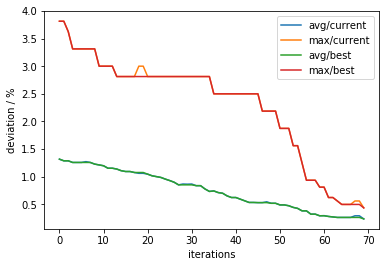

CPU times: user 2.74 s, sys: 88.2 ms, total: 2.83 s
Wall time: 2.87 s


In [104]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-1600'], 320, 'iv-1-1600-10', 0.005, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  1.38%  4.13%)
E- 6   : 13.63% - 13.12% =  0.50% -> adding molecule
Last:  1.38%  4.13%.   Current:  1.32%  3.81%

...

E- 1 :  0.19%
E- 2 :  0.38%
E- 3 :  0.31%
E- 4 :  0.31%
E- 5 :  0.31%
E- 6 :  0.13%
E- 7 :  0.44%
E- 8 :  0.31%
E- 9 :  0.06%
E-10 :  0.25%
E-11 :  0.19%
E-12 :  0.44%
E-13 :  0.31%
E-14 :  0.12%
Fl   :  0.25%
N    :  0.13%
O    :  0.12%
wH- 1:  0.00%
woH-7:  0.06%
woH-8:  0.31%
woH-9:  0.38%

All statistics met, done (71 iterations).
Best solution has average deviation  0.24% and max. deviation  0.44%.

CPU times: user 2.74 s, sys: 88.2 ms, total: 2.83 s
Wall time: 2.87 s

21 statistics in total, 2 sizewH bins, 15 energy b

#### n=4000

In [ ]:
%%time
run_sampling(valid3, 4000, 'ot-1-4000', 0.0005, 5000)

0.03/0.05 reached after 926 iterations.

Log excerpt:

    33 statistics in total, 14 sizewH bins, 15 energy bins.
    
    Iteration 1   (best so far:  0.32%  1.00%)
    woH-8: 13.75% - 14.12% = -0.38% -> removing molecule
    Last:  0.32%  1.00%.   Current:  0.32%  1.00%
    
    ...    
    
    Iteration 926   (best so far:  0.03%  0.05%)
    E- 1 :  2.40% -  2.35% =  0.05% -> okay
    E- 9 : 10.89% - 10.90% = -0.01% -> okay
    Fl   :  1.47% -  1.43% =  0.05% -> okay
    wH- 3:  5.11% -  5.08% =  0.03% -> okay
    E-11 :  5.45% -  5.50% = -0.05% -> okay
    E- 7 : 13.92% - 13.88% =  0.05% -> okay
    E- 5 :  9.65% -  9.60% =  0.05% -> okay
    wH- 9:  9.54% -  9.50% =  0.04% -> okay
    wH- 5: 10.58% - 10.60% = -0.02% -> okay
    E- 4 :  8.44% -  8.48% = -0.03% -> okay
    E-10 :  8.05% -  8.03% =  0.03% -> okay
    wH- 4:  7.83% -  7.88% = -0.05% -> okay
    wH-10: 10.13% - 10.10% =  0.03% -> okay
    wH-13:  2.37% -  2.40% = -0.03% -> okay
    E-14 :  1.75% -  1.80% = -0.05% -> okay
    woH-9: 83.84% - 83.88% = -0.04% -> okay
    N    : 61.13% - 61.15% = -0.02% -> okay
    E- 3 :  4.03% -  4.05% = -0.02% -> okay
    wH- 2:  3.02% -  3.05% = -0.03% -> okay
    O    : 85.16% - 85.12% =  0.04% -> okay
    woH-7:  2.42% -  2.38% =  0.04% -> okay
    wH-11:  3.40% -  3.38% =  0.03% -> okay
    wH- 8: 13.95% - 13.98% = -0.02% -> okay
    wH-12:  4.90% -  4.88% =  0.02% -> okay
    wH- 6: 13.04% - 13.05% = -0.01% -> okay
    wH- 1:  2.75% -  2.73% =  0.03% -> okay
    E- 8 : 13.17% - 13.15% =  0.02% -> okay
    E- 6 : 13.68% - 13.70% = -0.02% -> okay
    wH- 7: 13.39% - 13.40% = -0.01% -> okay
    E- 2 :  3.46% -  3.45% =  0.01% -> okay
    E-12 :  3.28% -  3.28% =  0.00% -> okay
    E-13 :  1.84% -  1.85% = -0.01% -> okay
    woH-8: 13.75% - 13.75% = -0.00% -> okay
    Last:  0.03%  0.05%.   Current:  0.03%  0.05%

    E- 1 :  0.05%
    E- 2 :  0.01%
    E- 3 :  0.02%
    E- 4 :  0.03%
    E- 5 :  0.05%
    E- 6 :  0.02%
    E- 7 :  0.05%
    E- 8 :  0.02%
    E- 9 :  0.01%
    E-10 :  0.03%
    E-11 :  0.05%
    E-12 :  0.00%
    E-13 :  0.01%
    E-14 :  0.05%
    Fl   :  0.05%
    N    :  0.02%
    O    :  0.04%
    wH- 1:  0.03%
    wH- 2:  0.03%
    wH- 3:  0.03%
    wH- 4:  0.05%
    wH- 5:  0.02%
    wH- 6:  0.01%
    wH- 7:  0.01%
    wH- 8:  0.02%
    wH- 9:  0.04%
    wH-10:  0.03%
    wH-11:  0.03%
    wH-12:  0.02%
    wH-13:  0.03%
    woH-7:  0.04%
    woH-8:  0.00%
    woH-9:  0.04%
    
    All statistics met, done (926 iterations).
    Best solution has average deviation  0.03% and max. deviation  0.05%.
    
    CPU times: user 45min 17s, sys: 28.1 s, total: 45min 45s
    Wall time: 46min

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-1', 0.001, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.72%  2.00%)
E-11 :  5.50% -  7.50% = -2.00% -> removing molecule
Last:  0.72%  2.00%.   Current:  0.72%  1.88%


...

E- 1 :  0.03%
E- 2 :  0.05%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.05%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.03%
E-14 :  0.05%
Fl   :  0.07%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (1482 iterations).
Best solution has average deviation  0.02% and max. deviation  0.07%.

CPU times: user 2min 8s, sys: 2.25 s, total: 2min 10s
Wall time: 2min 10s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-2', 0.001, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.53%  2.00%)
E- 9   : 10.90% - 10.25% =  0.65% -> adding molecule
Last:  0.53%  2.00%.   Current:  0.54%  2.00%
Acceptance probability: 94.23% -> accepting uphill step.

...

E- 1 :  0.03%
E- 2 :  0.05%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.08%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.03%
E-14 :  0.08%
Fl   :  0.05%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (466 iterations).
Best solution has average deviation  0.03% and max. deviation  0.08%.

CPU times: user 39 s, sys: 478 ms, total: 39.4 s
Wall time: 39.2 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-3', 0.001, 2500)

1 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.75%  2.62%)
E- 7   : 13.88% - 12.38% =  1.50% -> adding molecule
Last:  0.75%  2.62%.   Current:  0.75%  2.75%
Acceptance probability: 15.80% -> rejecting uphill step.

...

E- 1 :  0.03%
E- 2 :  0.05%
E- 3 :  0.08%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.08%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.10%
E-14 :  0.08%
Fl   :  0.05%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (759 iterations).
Best solution has average deviation  0.03% and max. deviation  0.10%.

CPU times: user 1min 4s, sys: 916 ms, total: 1min 5s
Wall time: 1min 5s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-4', 0.001, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.76%  2.65%)
N      : 61.15% - 58.50% =  2.65% -> adding molecule
Last:  0.76%  2.65%.   Current:  0.76%  2.52%


...

E- 1 :  0.03%
E- 2 :  0.05%
E- 3 :  0.08%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.05%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.10%
E-14 :  0.05%
Fl   :  0.07%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (1193 iterations).
Best solution has average deviation  0.03% and max. deviation  0.10%.

CPU times: user 1min 39s, sys: 1.35 s, total: 1min 40s
Wall time: 1min 40s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-5', 0.001, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.56%  1.73%)
woH-9  : 83.88% - 83.25% =  0.62% -> adding molecule
Last:  0.56%  1.73%.   Current:  0.54%  1.60%

...

E- 1 :  0.03%
E- 2 :  0.08%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.05%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.03%
E-14 :  0.08%
Fl   :  0.05%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (575 iterations).
Best solution has average deviation  0.03% and max. deviation  0.08%.

CPU times: user 45.2 s, sys: 515 ms, total: 45.7 s
Wall time: 45.3 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-6', 0.001, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.54%  1.52%)
E- 4   :  8.48% -  8.25% =  0.23% -> adding molecule
Last:  0.54%  1.52%.   Current:  0.51%  1.52%

...

E- 1 :  0.03%
E- 2 :  0.08%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.05%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.03%
E-14 :  0.08%
Fl   :  0.05%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (591 iterations).
Best solution has average deviation  0.03% and max. deviation  0.08%.

CPU times: user 45.5 s, sys: 463 ms, total: 46 s
Wall time: 45.6 s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-7', 0.001, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.70%  2.13%)
N      : 61.15% - 59.25% =  1.90% -> adding molecule
Last:  0.70%  2.13%.   Current:  0.68%  2.13%

...

E- 1 :  0.03%
E- 2 :  0.05%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.05%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.10%
E-14 :  0.08%
Fl   :  0.07%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (1106 iterations).
Best solution has average deviation  0.03% and max. deviation  0.10%.

CPU times: user 1min 25s, sys: 952 ms, total: 1min 26s
Wall time: 1min 25s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-8', 0.001, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.49%  1.50%)
E- 4   :  8.48% -  8.00% =  0.48% -> adding molecule
Last:  0.49%  1.50%.   Current:  0.49%  1.50%
Acceptance probability: 97.07% -> accepting uphill step.

...

E- 1 :  0.03%
E- 2 :  0.05%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.05%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.03%
E-14 :  0.05%
Fl   :  0.07%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (1116 iterations).
Best solution has average deviation  0.02% and max. deviation  0.07%.

CPU times: user 1min 26s, sys: 955 ms, total: 1min 27s
Wall time: 1min 26s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-9', 0.001, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.70%  4.35%)
N    : 61.15% - 65.50% = -4.35% -> removing molecule
Last:  0.70%  4.35%.   Current:  0.70%  4.23%

...

E- 1 :  0.03%
E- 2 :  0.08%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.05%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.03%
E-14 :  0.08%
Fl   :  0.05%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (1387 iterations).
Best solution has average deviation  0.03% and max. deviation  0.08%.

CPU times: user 1min 47s, sys: 1.19 s, total: 1min 48s
Wall time: 1min 47s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-4000'], 800, 'iv-1-4000-10', 0.001, 2500)

21 statistics in total, 2 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.48%  1.02%)
E- 7 : 13.88% - 14.75% = -0.87% -> removing molecule
Last:  0.48%  1.02%.   Current:  0.47%  1.02%

...

E- 1 :  0.03%
E- 2 :  0.08%
E- 3 :  0.05%
E- 4 :  0.03%
E- 5 :  0.03%
E- 6 :  0.05%
E- 7 :  0.00%
E- 8 :  0.03%
E- 9 :  0.03%
E-10 :  0.03%
E-11 :  0.00%
E-12 :  0.03%
E-13 :  0.03%
E-14 :  0.08%
Fl   :  0.05%
N    :  0.03%
O    :  0.00%
wH- 1:  0.00%
woH-7:  0.00%
woH-8:  0.00%
woH-9:  0.00%

All statistics met, done (884 iterations).
Best solution has average deviation  0.03% and max. deviation  0.08%.

CPU times: user 1min 8s, sys: 756 ms, total: 1min 9s
Wall time: 1min 8s

#### n=10000

In [ ]:
%%time
run_sampling(valid3, 10000, 'ot-1-10000', 0.0005, 5000)

0.03/0.05 reached after 987 iterations (52 min CPU time).

Log excerpt:

    33 statistics in total, 14 sizewH bins, 15 energy bins.
    
    Iteration 1   (best so far:  0.22%  1.01%)
    wH- 4  :  7.83% -  7.28% =  0.55% -> adding molecule
    Last:  0.22%  1.01%.   Current:  0.22%  1.01%
    Acceptance probability: 99.60% -> accepting uphill step.
    
    ...
    
    Iteration 987   (best so far:  0.03%  0.05%)
    wH- 8: 13.95% - 13.94% =  0.01% -> okay
    woH-8: 13.75% - 13.76% = -0.01% -> okay
    E- 4 :  8.44% -  8.49% = -0.05% -> okay
    woH-9: 83.84% - 83.79% =  0.05% -> okay
    E-10 :  8.05% -  8.10% = -0.05% -> okay
    O    : 85.16% - 85.21% = -0.05% -> okay
    E-13 :  1.84% -  1.88% = -0.04% -> okay
    E- 7 : 13.92% - 13.88% =  0.04% -> okay
    E- 6 : 13.68% - 13.64% =  0.04% -> okay
    wH- 1:  2.75% -  2.76% = -0.01% -> okay
    woH-7:  2.42% -  2.45% = -0.03% -> okay
    wH- 4:  7.83% -  7.85% = -0.02% -> okay
    wH- 6: 13.04% - 13.08% = -0.04% -> okay
    E- 5 :  9.65% -  9.61% =  0.04% -> okay
    E- 9 : 10.89% - 10.85% =  0.04% -> okay
    E-14 :  1.75% -  1.78% = -0.03% -> okay
    wH- 7: 13.39% - 13.43% = -0.04% -> okay
    wH- 3:  5.11% -  5.07% =  0.04% -> okay
    E-11 :  5.45% -  5.50% = -0.05% -> okay
    E- 2 :  3.46% -  3.47% = -0.01% -> okay
    wH- 5: 10.58% - 10.62% = -0.04% -> okay
    wH-13:  2.37% -  2.40% = -0.03% -> okay
    wH- 9:  9.54% -  9.51% =  0.03% -> okay
    N    : 61.13% - 61.15% = -0.02% -> okay
    wH-10: 10.13% - 10.11% =  0.02% -> okay
    E- 8 : 13.17% - 13.12% =  0.05% -> okay
    E-12 :  3.28% -  3.24% =  0.04% -> okay
    wH-11:  3.40% -  3.37% =  0.03% -> okay
    wH- 2:  3.02% -  3.01% =  0.01% -> okay
    wH-12:  4.90% -  4.85% =  0.05% -> okay
    E- 3 :  4.03% -  4.05% = -0.02% -> okay
    E- 1 :  2.40% -  2.39% =  0.01% -> okay
    Fl   :  1.47% -  1.48% = -0.01% -> okay
    Last:  0.03%  0.05%.   Current:  0.03%  0.05%
    
    E- 1 :  0.01%
    E- 2 :  0.01%
    E- 3 :  0.02%
    E- 4 :  0.05%
    E- 5 :  0.04%
    E- 6 :  0.04%
    E- 7 :  0.04%
    E- 8 :  0.05%
    E- 9 :  0.04%
    E-10 :  0.05%
    E-11 :  0.05%
    E-12 :  0.04%
    E-13 :  0.04%
    E-14 :  0.03%
    Fl   :  0.01%
    N    :  0.02%
    O    :  0.05%
    wH- 1:  0.01%
    wH- 2:  0.01%
    wH- 3:  0.04%
    wH- 4:  0.02%
    wH- 5:  0.04%
    wH- 6:  0.04%
    wH- 7:  0.04%
    wH- 8:  0.01%
    wH- 9:  0.03%
    wH-10:  0.02%
    wH-11:  0.03%
    wH-12:  0.05%
    wH-13:  0.03%
    woH-7:  0.03%
    woH-8:  0.01%
    woH-9:  0.05%
    
    All statistics met, done (987 iterations).
    Best solution has average deviation  0.03% and max. deviation  0.05%.
    
    CPU times: user 51min 23s, sys: 32.6 s, total: 51min 56s
    Wall time: 52min 13s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-1', 0.0005, 10000)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.42%  1.22%)
E-10   :  8.10% -  7.15% =  0.95% -> adding molecule
Last:  0.42%  1.22%.   Current:  0.43%  1.22%
Acceptance probability: 98.96% -> accepting uphill step.

...

E- 1 :  0.01%
E- 2 :  0.03%
E- 3 :  0.00%
E- 4 :  0.01%
E- 5 :  0.01%
E- 6 :  0.01%
E- 7 :  0.03%
E- 8 :  0.02%
E- 9 :  0.00%
E-10 :  0.00%
E-11 :  0.00%
E-12 :  0.01%
E-13 :  0.02%
E-14 :  0.03%
Fl   :  0.03%
N    :  0.00%
O    :  0.01%
wH- 1:  0.01%
wH- 2:  0.04%
wH- 3:  0.05%
wH- 4:  0.02%
woH-7:  0.00%
woH-8:  0.04%
woH-9:  0.04%

All statistics met, done (987 iterations).
Best solution has average deviation  0.02% and max. deviation  0.05%.

CPU times: user 3min 33s, sys: 889 ms, total: 3min 34s
Wall time: 3min 33s

​


In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-2', 0.0005, 2500)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.38%  1.25%)
wH- 3: 23.45% - 24.70% = -1.25% -> removing molecule
Last:  0.38%  1.25%.   Current:  0.37%  1.20%

...

E- 1 :  0.01%
E- 2 :  0.03%
E- 3 :  0.00%
E- 4 :  0.01%
E- 5 :  0.04%
E- 6 :  0.04%
E- 7 :  0.03%
E- 8 :  0.02%
E- 9 :  0.00%
E-10 :  0.00%
E-11 :  0.00%
E-12 :  0.04%
E-13 :  0.02%
E-14 :  0.02%
Fl   :  0.02%
N    :  0.05%
O    :  0.01%
wH- 1:  0.01%
wH- 2:  0.04%
wH- 3:  0.05%
wH- 4:  0.02%
woH-7:  0.00%
woH-8:  0.01%
woH-9:  0.01%

All statistics met, done (1899 iterations).
Best solution has average deviation  0.02% and max. deviation  0.05%.

CPU times: user 7min 13s, sys: 3.82 s, total: 7min 17s
Wall time: 7min 17s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-3', 0.0005, 2500)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.36%  1.52%)
E- 1 :  2.39% -  2.75% = -0.36% -> removing molecule
Last:  0.36%  1.52%.   Current:  0.36%  1.52%

...

E- 1 :  0.01%
E- 2 :  0.02%
E- 3 :  0.00%
E- 4 :  0.01%
E- 5 :  0.04%
E- 6 :  0.04%
E- 7 :  0.02%
E- 8 :  0.03%
E- 9 :  0.00%
E-10 :  0.00%
E-11 :  0.00%
E-12 :  0.04%
E-13 :  0.03%
E-14 :  0.02%
Fl   :  0.03%
N    :  0.00%
O    :  0.04%
wH- 1:  0.04%
wH- 2:  0.01%
wH- 3:  0.00%
wH- 4:  0.03%
woH-7:  0.00%
woH-8:  0.01%
woH-9:  0.01%

All statistics met, done (1160 iterations).
Best solution has average deviation  0.02% and max. deviation  0.04%.

CPU times: user 4min 37s, sys: 3.2 s, total: 4min 40s
Wall time: 4min 41s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-4', 0.0005, 2500)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.38%  1.40%)
E- 1 :  2.39% -  2.85% = -0.46% -> removing molecule
Last:  0.38%  1.40%.   Current:  0.38%  1.35%

...

E- 1 :  0.04%
E- 2 :  0.02%
E- 3 :  0.00%
E- 4 :  0.01%
E- 5 :  0.04%
E- 6 :  0.06%
E- 7 :  0.13%
E- 8 :  0.02%
E- 9 :  0.05%
E-10 :  0.00%
E-11 :  0.05%
E-12 :  0.01%
E-13 :  0.03%
E-14 :  0.02%
Fl   :  0.03%
N    :  0.05%
O    :  0.06%
wH- 1:  0.04%
wH- 2:  0.06%
wH- 3:  0.00%
wH- 4:  0.02%
woH-7:  0.00%
woH-8:  0.04%
woH-9:  0.04%

MAXIMUM NUMBER OF 2500 ITERATIONS REACHED, ABORTING
Best solution has average deviation  0.02% and max. deviation  0.05%.

CPU times: user 8min 53s, sys: 2.8 s, total: 8min 55s
Wall time: 8min 54s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-5', 0.0005, 2500)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.40%  1.14%)
woH-7:  2.45% -  2.70% = -0.25% -> removing molecule
Last:  0.40%  1.14%.   Current:  0.39%  1.09%

...

E- 1 :  0.04%
E- 2 :  0.02%
E- 3 :  0.00%
E- 4 :  0.04%
E- 5 :  0.04%
E- 6 :  0.01%
E- 7 :  0.02%
E- 8 :  0.03%
E- 9 :  0.00%
E-10 :  0.00%
E-11 :  0.00%
E-12 :  0.04%
E-13 :  0.02%
E-14 :  0.02%
Fl   :  0.03%
N    :  0.00%
O    :  0.04%
wH- 1:  0.04%
wH- 2:  0.04%
wH- 3:  0.05%
wH- 4:  0.03%
woH-7:  0.00%
woH-8:  0.01%
woH-9:  0.01%

All statistics met, done (1185 iterations).
Best solution has average deviation  0.02% and max. deviation  0.05%.

CPU times: user 4min 5s, sys: 1.1 s, total: 4min 6s
Wall time: 4min 5s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-6', 0.0005, 2500)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.47%  1.31%)
wH- 4: 20.73% - 21.50% = -0.77% -> removing molecule
Last:  0.47%  1.31%.   Current:  0.46%  1.31%

...

E- 1 :  0.04%
E- 2 :  0.03%
E- 3 :  0.00%
E- 4 :  0.01%
E- 5 :  0.04%
E- 6 :  0.04%
E- 7 :  0.02%
E- 8 :  0.02%
E- 9 :  0.00%
E-10 :  0.00%
E-11 :  0.00%
E-12 :  0.01%
E-13 :  0.02%
E-14 :  0.03%
Fl   :  0.02%
N    :  0.05%
O    :  0.01%
wH- 1:  0.01%
wH- 2:  0.04%
wH- 3:  0.00%
wH- 4:  0.03%
woH-7:  0.00%
woH-8:  0.01%
woH-9:  0.01%

All statistics met, done (1699 iterations).
Best solution has average deviation  0.02% and max. deviation  0.05%.

CPU times: user 5min 59s, sys: 2.05 s, total: 6min 2s
Wall time: 6min 1s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-7', 0.0005, 10000)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.60%  2.20%)
woH-9  : 83.79% - 82.85% =  0.94% -> adding molecule
Last:  0.60%  2.20%.   Current:  0.60%  2.25%
Acceptance probability: 46.75% -> rejecting uphill step.

...

E- 1 :  0.04%
E- 2 :  0.03%
E- 3 :  0.00%
E- 4 :  0.01%
E- 5 :  0.01%
E- 6 :  0.01%
E- 7 :  0.02%
E- 8 :  0.03%
E- 9 :  0.00%
E-10 :  0.00%
E-11 :  0.00%
E-12 :  0.04%
E-13 :  0.02%
E-14 :  0.03%
Fl   :  0.03%
N    :  0.05%
O    :  0.01%
wH- 1:  0.04%
wH- 2:  0.01%
wH- 3:  0.00%
wH- 4:  0.03%
woH-7:  0.00%
woH-8:  0.04%
woH-9:  0.04%

All statistics met, done (1421 iterations).
Best solution has average deviation  0.02% and max. deviation  0.05%.

CPU times: user 4min 58s, sys: 1.29 s, total: 4min 59s
Wall time: 4min 58s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-8', 0.0005, 10000)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.59%  2.01%)
wH- 4: 20.73% - 21.45% = -0.72% -> removing molecule
Last:  0.59%  2.01%.   Current:  0.59%  1.96%

...

E- 1 :  0.01%
E- 2 :  0.03%
E- 3 :  0.00%
E- 4 :  0.04%
E- 5 :  0.04%
E- 6 :  0.04%
E- 7 :  0.02%
E- 8 :  0.02%
E- 9 :  0.00%
E-10 :  0.00%
E-11 :  0.00%
E-12 :  0.01%
E-13 :  0.03%
E-14 :  0.02%
Fl   :  0.02%
N    :  0.00%
O    :  0.01%
wH- 1:  0.01%
wH- 2:  0.04%
wH- 3:  0.00%
wH- 4:  0.03%
woH-7:  0.00%
woH-8:  0.04%
woH-9:  0.04%

All statistics met, done (1386 iterations).
Best solution has average deviation  0.02% and max. deviation  0.04%.

CPU times: user 4min 49s, sys: 1.28 s, total: 4min 50s
Wall time: 4min 49s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-9', 0.0005, 10000)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.63%  2.31%)
O    : 85.21% - 86.00% = -0.79% -> removing molecule
Last:  0.63%  2.31%.   Current:  0.64%  2.31%
Acceptance probability: 97.94% -> accepting uphill step.

...

E- 1 :  0.01%
E- 2 :  0.03%
E- 3 :  0.00%
E- 4 :  0.01%
E- 5 :  0.04%
E- 6 :  0.04%
E- 7 :  0.03%
E- 8 :  0.03%
E- 9 :  0.00%
E-10 :  0.00%
E-11 :  0.00%
E-12 :  0.04%
E-13 :  0.02%
E-14 :  0.03%
Fl   :  0.03%
N    :  0.05%
O    :  0.01%
wH- 1:  0.04%
wH- 2:  0.01%
wH- 3:  0.00%
wH- 4:  0.03%
woH-7:  0.00%
woH-8:  0.01%
woH-9:  0.01%

All statistics met, done (2029 iterations).
Best solution has average deviation  0.02% and max. deviation  0.05%.

CPU times: user 6min 56s, sys: 1.87 s, total: 6min 58s
Wall time: 6min 57s

In [ ]:
%%time
inds = load_data_splits(filename)
run_sampling(inds['ot-1-10000'], 2000, 'iv-1-10000-10', 0.0005, 10000)

24 statistics in total, 5 sizewH bins, 15 energy bins.

Iteration 1   (best so far:  0.50%  1.47%)
woH-7:  2.45% -  2.80% = -0.35% -> removing molecule
Last:  0.50%  1.47%.   Current:  0.50%  1.47%
Acceptance probability: 100.00% -> accepting uphill step.

...

E- 1 :  0.01%
E- 2 :  0.02%
E- 3 :  0.00%
E- 4 :  0.01%
E- 5 :  0.04%
E- 6 :  0.04%
E- 7 :  0.02%
E- 8 :  0.02%
E- 9 :  0.00%
E-10 :  0.00%
E-11 :  0.00%
E-12 :  0.01%
E-13 :  0.02%
E-14 :  0.03%
Fl   :  0.03%
N    :  0.05%
O    :  0.04%
wH- 1:  0.04%
wH- 2:  0.04%
wH- 3:  0.05%
wH- 4:  0.03%
woH-7:  0.00%
woH-8:  0.01%
woH-9:  0.01%

All statistics met, done (538 iterations).
Best solution has average deviation  0.02% and max. deviation  0.05%.

CPU times: user 1min 51s, sys: 493 ms, total: 1min 52s
Wall time: 1min 51s

# Validation of sampled subsets

In [8]:
valsetsize = 10000
trainsetsizes = [100, 250, 650, 1600, 4000, 10000]

In [13]:
toosmall = np.asarray([i for i in valid if sizeswoH[i] <= 6])
inds = load_data_splits(filename)

numov, numiv = 10, 10

ovkeys = [k for k in inds.keys() if re.fullmatch('ov-\d+', k)]
otkeys = [k for k in inds.keys() if re.fullmatch('ot-\d+-\d+', k)]
ivkeys = [k for k in inds.keys() if re.fullmatch('iv-\d+-\d+-\d+', k)]

assert len(ovkeys) == numov, "all outer validation subsets present"
assert len(otkeys) == numov * len(trainsetsizes), "all training subsets present"
assert len(ivkeys) == numov * len(trainsetsizes) * numiv, "all inner splits present"

print(f"{len(ovkeys):d} outer splits.")
for ov in sorted(ovkeys):
    ovi = ov.split('-')[1]  # index of outer validation set
    
    assert np.unique(inds[ov]).size == inds[ov].size, 'unique entries'
    assert np.intersect1d(inds[ov], np.asarray(uncharacterized)-1).size == 0, 'excluded indices from uncharacterized file'
    assert np.intersect1d(inds[ov], np.asarray(difficult)-1).size == 0, 'excluded indices from readme file'
    assert np.intersect1d(inds[ov], toosmall).size == 0, 'excluded due to size'
    print(f"outer validation set {ov} passed.")
    
    for ot in sorted(otkeys):
        oti, otj = ot.split('-')[1:3]  # outer training set indices (ov, tss)
        if oti != ovi: continue

        assert np.unique(inds[ot]).size == inds[ot].size, 'unique entries'
        assert np.intersect1d(inds[ot], np.asarray(uncharacterized)-1).size == 0, 'excluded indices from uncharacterized file'
        assert np.intersect1d(inds[ot], np.asarray(difficult)-1).size == 0, 'excluded indices from readme file'
        assert np.intersect1d(inds[ot], toosmall).size == 0, 'excluded due to size'
        assert np.intersect1d(inds[ot], inds['ov-'+oti]).size == 0, "no overlap between training and validation set"
        print(f"    outer training set {ot} passed.")
        
        for iv in sorted(ivkeys):
            ivi, ivj, ivk = iv.split('-')[1:4]
            if ivi != ovi: continue
            if ivj != otj: continue
            
            assert np.unique(inds[iv]).size == inds[iv].size, 'unique entries'
            assert np.in1d(inds[iv], inds[ot]).all(), "split is subset of outer training set"
            assert inds[iv].size == round(inds[ot].size * 0.2), "correct size"
            print(f"        inner validation set {iv} passed.")
            
print("All checks passed.")

10 outer splits.
outer validation set ov-1 passed.
    outer training set ot-1-100 passed.
        inner validation set iv-1-100-1 passed.
        inner validation set iv-1-100-10 passed.
        inner validation set iv-1-100-2 passed.
        inner validation set iv-1-100-3 passed.
        inner validation set iv-1-100-4 passed.
        inner validation set iv-1-100-5 passed.
        inner validation set iv-1-100-6 passed.
        inner validation set iv-1-100-7 passed.
        inner validation set iv-1-100-8 passed.
        inner validation set iv-1-100-9 passed.
    outer training set ot-1-10000 passed.
        inner validation set iv-1-10000-1 passed.
        inner validation set iv-1-10000-10 passed.
        inner validation set iv-1-10000-2 passed.
        inner validation set iv-1-10000-3 passed.
        inner validation set iv-1-10000-4 passed.
        inner validation set iv-1-10000-5 passed.
        inner validation set iv-1-10000-6 passed.
        inner validation set iv-1-1

        inner validation set iv-4-4000-2 passed.
        inner validation set iv-4-4000-3 passed.
        inner validation set iv-4-4000-4 passed.
        inner validation set iv-4-4000-5 passed.
        inner validation set iv-4-4000-6 passed.
        inner validation set iv-4-4000-7 passed.
        inner validation set iv-4-4000-8 passed.
        inner validation set iv-4-4000-9 passed.
    outer training set ot-4-650 passed.
        inner validation set iv-4-650-1 passed.
        inner validation set iv-4-650-10 passed.
        inner validation set iv-4-650-2 passed.
        inner validation set iv-4-650-3 passed.
        inner validation set iv-4-650-4 passed.
        inner validation set iv-4-650-5 passed.
        inner validation set iv-4-650-6 passed.
        inner validation set iv-4-650-7 passed.
        inner validation set iv-4-650-8 passed.
        inner validation set iv-4-650-9 passed.
outer validation set ov-5 passed.
    outer training set ot-5-100 passed.
        inner

        inner validation set iv-9-10000-2 passed.
        inner validation set iv-9-10000-3 passed.
        inner validation set iv-9-10000-4 passed.
        inner validation set iv-9-10000-5 passed.
        inner validation set iv-9-10000-6 passed.
        inner validation set iv-9-10000-7 passed.
        inner validation set iv-9-10000-8 passed.
        inner validation set iv-9-10000-9 passed.
    outer training set ot-9-1600 passed.
        inner validation set iv-9-1600-1 passed.
        inner validation set iv-9-1600-10 passed.
        inner validation set iv-9-1600-2 passed.
        inner validation set iv-9-1600-3 passed.
        inner validation set iv-9-1600-4 passed.
        inner validation set iv-9-1600-5 passed.
        inner validation set iv-9-1600-6 passed.
        inner validation set iv-9-1600-7 passed.
        inner validation set iv-9-1600-8 passed.
        inner validation set iv-9-1600-9 passed.
    outer training set ot-9-250 passed.
        inner validation set